# Names 
Spencer Bernardo-Cheng
Max Goldstein
Robbie Keehan

# Data Preparation

Our dataset is used to predict the price of Amazon. In the dataset, we used the opening and closing prices of Amazon, Google, Microsoft, Netflix, and Facebook. We used other tech companies to provide the model with information about the tech company sector of the stock market. We also used common market indicators such as the SMA-7, SMA-21, SMA-90, RSI-14, and ADX. All of these combined are used to predict the percent change in price for the next days closing price. The data is modified to all be in percentage change, so that the model does not simply learn to predict the price of the next day based mostly off of the previous day. We challenge the RNN to determine price change as opposed price values.

In [1]:
import numpy as np
import pandas as pd
datafb = pd.read_csv("./FB.csv")
datagoogle = pd.read_csv("./GOOGL.csv")
datamsft = pd.read_csv("./MSFT.csv")
dataam = pd.read_csv("./AMZN (1).csv")
datanflx = pd.read_csv("./NFLX.csv")

del datafb['Date']
del datagoogle['Date']
del datamsft['Date']
del datanflx['Date']


data = pd.concat([datafb, datagoogle, datamsft,datanflx, dataam ], axis=1, sort=False)
data = data[89:]
del data['Change']
del data['Gain']
del data['Loss']
del data['Average Gain']
del data['Average Loss']
del data['RS']
del data['DM+1']
del data['DM-1']
del data['TR-14']
del data['DM+1-14']
del data['DM-1+14']
del data['dl+1-14']
del data['dl-1-14']
del data['dl14diff']
del data['dl14sum']
del data['DX']
del data['TR']
ogdates = []
for val in data['Date']:
    ogdates.append(val)
del data['Date']

predictedDays = 14
up = .03
down =-.03
## Time difference the data
colheaders = data.columns[0:-3]
og = []
for val in data['Close-amzn']:
    og.append(val)
for header in colheaders: 
    for i in range(1, len(data)):
        perchange =((data[header].iloc[i]) - (data[header].iloc[i - 1]))/float(data[header].iloc[i-1])
        data.set_value(89+i,"pc-"+header,perchange)
#         data["pc"+header].at[90+i]= perchange
data = data[1:]
ydata = data['pc-Close-amzn']
# ydata = ydata.apply(lambda x:2 if x>=up else (1 if (x< up and x > down) else 0))
ydata = pd.DataFrame(ydata)
ydata['newy'] = ""
# created target data in format to match output of multiple timesteps of 14 days ahead
# [0,1,2,3,4,5,6,7]
# [1,2,3,4,5,6,7,8]
for index, row in ydata.iterrows():
    temp = np.array(ydata['pc-Close-amzn'][index-90:index-90+predictedDays].values)
    ydata['newy'].at[index] = temp
    
# removed last 14 because their targets are not able to created
ydata = ydata[0:-(predictedDays-1)]
data = data[0:-(predictedDays-1)]

del ydata['pc-Close-amzn']

xdata =data[['RSI-14 Day', 'ADX',
       'pc-Open-fb', 'pc-High-fb', 'pc-Low-fb', 'pc-Close-fb',
       'pc-Adj Close-fb', 'pc-Volume-fb', 'pc-Open-googl', 'pc-High-googl',
       'pc-Low-googl', 'pc-Close-googl', 'pc-Adj Close-googl',
       'pc-Volume-googl', 'pc-Open-msft', 'pc-High-msft', 'pc-Low-msft',
       'pc-Close-msft', 'pc-Adj Close-msft', 'pc-Volume-msft', 'pc-Open-nflx',
       'pc-High-nflx', 'pc-Low-nflx', 'pc-Close-nflx', 'pc-Adj Close-nflx',
       'pc-Volume-nflx', 'pc-Open-amzn', 'pc-High-amzn', 'pc-Low-amzn',
       'pc-Close-amzn', 'pc-Adj Close-amzn', 'pc-Volume-amzn', 'pc-SMA-7',
       'pc-SMA-21', 'pc-SMA-90']]


data = data[0:-1]
xdata = xdata[0:-1]
ydata = ydata[0:-1]
# data = data.T


//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


# Evaluation Criteria
We believe that using mean squared error is the best evaluation criteria for our use case of stock trading and because our model is performing a regression task as opposed to a classification task. If the stock prediction is too high or too low in either direction then it will result in sub-optimal trades. We decided to do mean squared error instead mean absolute error because the larger the error than the more that the trade could cost us. 

# Min-Max Scaling the Time Series

Scaling the data became necessary so as to prevent the model from thinking that higher prices have a higher significance in the model

In [2]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(xdata.iloc[:,:].values)
print(x_scaled)



[[0.35811382 0.15022488 0.40722014 ... 0.53721892 0.45230866 0.64160589]
 [0.26414926 0.12331708 0.35961381 ... 0.50635447 0.41867806 0.57327146]
 [0.25300192 0.10448737 0.40286589 ... 0.51153038 0.41312322 0.576277  ]
 ...
 [0.3029723  0.1344608  0.461637   ... 0.50352112 0.48231708 0.23750753]
 [0.31038595 0.1153046  0.38866776 ... 0.50862139 0.47320208 0.21748327]
 [0.25243424 0.13533161 0.42314792 ... 0.49730187 0.44639693 0.21806241]]


# Utilizing Time Series Generator

This time series generator function helped format our x data into chunks of 90 days for which we are to then predict the following 14 days. 

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, Lambda, Dropout,GRU
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 2
series = np.array(x_scaled)
target = np.array(ydata)
generator = TimeseriesGenerator(series, target, length=90, batch_size=1)
xtime = []
ytarget =[]
for i in range(len(generator)):
    x, y = generator[i]
    xtime.append(x[0])
xtime = np.array(xtime)

target = target[90:]
newtarget = []
for val in target:
    newtarget.append(np.array(val[0]))
ytarget = np.array(newtarget)
print(ytarget.shape)


Using TensorFlow backend.


(1698, 14)


# 10 Fold Cross Validation

We did 10  folds because our dataset was small and only included 1788 data points. This enabled us to get see if the model would make accurate predictions at any point in time throughout our dataset and not concentrate on only the last 20% of the dataset. Although our dataset is timeseries, and 10 fold would be untraditional, we believe that any 90 day period  should be considered independent to another 90 day period to predict the following 14 days of price action. 

# LSTM

In [13]:
from sklearn.model_selection import KFold



kfold = KFold(n_splits=10, shuffle=False, random_state=None)
# fit model
historiesLSTM = []
# scores = []
lstmModels=[]
k = 1
# for train_index, test_index in kfold.split(xtime, ytarget):
for train_index, test_index in kfold.split(xtime, ytarget):
    model = Sequential()
    model.add(LSTM(100,dropout=.2,activation='relu', input_shape=(90, 35), return_sequences=True))
    model.add(Lambda(lambda x: x[:, -predictedDays:, :]))
    model.add(Dense(1))

    model.summary()
    model.compile(optimizer='adam', loss='mse')
    print("Fold: ", k)
    x_train, x_test = xtime[train_index], xtime[test_index]
    y_train, y_test = ytarget[train_index], ytarget[test_index]
    print(y_train.shape)
    y_train = y_train.reshape(y_train.shape[0],14,1)
    y_test= y_test.reshape(y_test.shape[0],14,1)
    
    historiesLSTM.append(model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=1000, verbose=1))
    lstmModels.append(model)
    k += 1
#     score = model.score(x_train[test_index], y_train[test_index])
#     scores.append(score)
#     print('Fold: %s, Acc: %.3f' % (k+1, score))
    
# print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=50, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 90, 100)           54400     
_________________________________________________________________
lambda_17 (Lambda)           (None, 14, 100)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 14, 1)             101       
Total params: 54,501
Trainable params: 54,501
Non-trainable params: 0
_________________________________________________________________
Fold:  1
(1528, 14)
Train on 1528 samples, validate on 170 samples
Epoch 1/1000
1528/1528 [==============================] - 5s 4ms/step - loss: 0.0023 - val_loss: 3.3907e-04
Epoch 2/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.6010e-04 - val_loss: 2.8540e-04
Epoch 3/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4338e-04 - val_loss: 2.8724e-04
Epo

1528/1528 [==============================] - 3s 2ms/step - loss: 3.5187e-04 - val_loss: 2.8738e-04
Epoch 67/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5053e-04 - val_loss: 2.9177e-04
Epoch 68/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4737e-04 - val_loss: 2.8984e-04
Epoch 69/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4851e-04 - val_loss: 2.9356e-04
Epoch 70/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5120e-04 - val_loss: 2.9036e-04
Epoch 71/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4972e-04 - val_loss: 2.9374e-04
Epoch 72/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5085e-04 - val_loss: 2.9472e-04
Epoch 73/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4928e-04 - val_loss: 2.9802e-04
Epoch 74/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5023e-04 - val_loss: 3.0229e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.4550e-04 - val_loss: 3.0173e-04
Epoch 139/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3689e-04 - val_loss: 3.0594e-04
Epoch 140/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3701e-04 - val_loss: 3.1084e-04
Epoch 141/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3070e-04 - val_loss: 3.0404e-04
Epoch 142/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3056e-04 - val_loss: 2.9660e-04
Epoch 143/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3074e-04 - val_loss: 3.0429e-04
Epoch 144/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3220e-04 - val_loss: 3.1527e-04
Epoch 145/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3257e-04 - val_loss: 3.1047e-04
Epoch 146/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3595e-04 - val_loss: 

Epoch 210/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8488e-04 - val_loss: 3.1163e-04
Epoch 211/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8235e-04 - val_loss: 3.1775e-04
Epoch 212/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8250e-04 - val_loss: 3.1907e-04
Epoch 213/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8305e-04 - val_loss: 3.0976e-04
Epoch 214/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8147e-04 - val_loss: 3.3192e-04
Epoch 215/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8756e-04 - val_loss: 3.1619e-04
Epoch 216/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7833e-04 - val_loss: 3.0954e-04
Epoch 217/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7829e-04 - val_loss: 3.1213e-04
Epoch 218/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7673e-

Epoch 282/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0868e-04 - val_loss: 3.4112e-04
Epoch 283/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0615e-04 - val_loss: 3.5445e-04
Epoch 284/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0851e-04 - val_loss: 3.4190e-04
Epoch 285/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0616e-04 - val_loss: 3.5789e-04
Epoch 286/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9954e-04 - val_loss: 3.5603e-04
Epoch 287/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0381e-04 - val_loss: 3.5662e-04
Epoch 288/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9987e-04 - val_loss: 3.4908e-04
Epoch 289/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0015e-04 - val_loss: 3.6150e-04
Epoch 290/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9845e-

Epoch 354/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5082e-04 - val_loss: 5.2427e-04
Epoch 355/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4752e-04 - val_loss: 4.4112e-04
Epoch 356/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4162e-04 - val_loss: 4.6737e-04
Epoch 357/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4131e-04 - val_loss: 4.5285e-04
Epoch 358/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4376e-04 - val_loss: 4.5382e-04
Epoch 359/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4066e-04 - val_loss: 4.6649e-04
Epoch 360/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.3578e-04 - val_loss: 4.7847e-04
Epoch 361/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3924e-04 - val_loss: 4.8991e-04
Epoch 362/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4173e-

Epoch 426/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0266e-04 - val_loss: 4.4086e-04
Epoch 427/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0259e-04 - val_loss: 4.2555e-04
Epoch 428/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0513e-04 - val_loss: 4.4428e-04
Epoch 429/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0049e-04 - val_loss: 4.1674e-04
Epoch 430/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.7268e-05 - val_loss: 4.7015e-04
Epoch 431/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.3390e-05 - val_loss: 4.7699e-04
Epoch 432/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.7032e-05 - val_loss: 4.5999e-04
Epoch 433/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.6502e-05 - val_loss: 4.8705e-04
Epoch 434/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.7042e-

Epoch 498/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.7828e-05 - val_loss: 4.1709e-04
Epoch 499/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.1435e-05 - val_loss: 4.2392e-04
Epoch 500/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2062e-05 - val_loss: 4.3932e-04
Epoch 501/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.3961e-05 - val_loss: 4.3865e-04
Epoch 502/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.4440e-05 - val_loss: 4.4456e-04
Epoch 503/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.3975e-05 - val_loss: 4.3460e-04
Epoch 504/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9118e-05 - val_loss: 4.6304e-04
Epoch 505/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7718e-05 - val_loss: 4.0313e-04
Epoch 506/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0116e-

Epoch 570/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4493e-05 - val_loss: 4.2722e-04
Epoch 571/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6943e-05 - val_loss: 4.6740e-04
Epoch 572/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5396e-05 - val_loss: 4.1198e-04
Epoch 573/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6291e-05 - val_loss: 4.3860e-04
Epoch 574/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.9963e-05 - val_loss: 4.4288e-04
Epoch 575/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2522e-05 - val_loss: 4.4726e-04
Epoch 576/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2827e-05 - val_loss: 4.2781e-04
Epoch 577/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3348e-05 - val_loss: 4.1818e-04
Epoch 578/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.2758e-

Epoch 642/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6418e-05 - val_loss: 3.9455e-04
Epoch 643/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6400e-05 - val_loss: 4.0501e-04
Epoch 644/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3912e-05 - val_loss: 3.8783e-04
Epoch 645/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1098e-05 - val_loss: 3.8680e-04
Epoch 646/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2786e-05 - val_loss: 3.8699e-04
Epoch 647/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.2801e-05 - val_loss: 3.7781e-04
Epoch 648/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5159e-05 - val_loss: 3.8367e-04
Epoch 649/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2524e-05 - val_loss: 3.8648e-04
Epoch 650/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1690e-

Epoch 714/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4130e-05 - val_loss: 3.5305e-04
Epoch 715/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3465e-05 - val_loss: 3.6108e-04
Epoch 716/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3887e-05 - val_loss: 3.5195e-04
Epoch 717/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4475e-05 - val_loss: 3.6206e-04
Epoch 718/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3261e-05 - val_loss: 3.6049e-04
Epoch 719/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5627e-05 - val_loss: 3.5747e-04
Epoch 720/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8713e-05 - val_loss: 3.5560e-04
Epoch 721/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8250e-05 - val_loss: 3.7135e-04
Epoch 722/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6479e-

Epoch 786/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.9456e-05 - val_loss: 3.4972e-04
Epoch 787/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8036e-05 - val_loss: 3.5058e-04
Epoch 788/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1458e-05 - val_loss: 3.5536e-04
Epoch 789/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.0983e-05 - val_loss: 3.5746e-04
Epoch 790/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0549e-05 - val_loss: 3.6375e-04
Epoch 791/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0321e-05 - val_loss: 3.7736e-04
Epoch 792/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8357e-05 - val_loss: 3.5761e-04
Epoch 793/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8571e-05 - val_loss: 3.5534e-04
Epoch 794/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7617e-

Epoch 858/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7902e-05 - val_loss: 3.4115e-04
Epoch 859/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5429e-05 - val_loss: 3.5470e-04
Epoch 860/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6414e-05 - val_loss: 3.4932e-04
Epoch 861/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7179e-05 - val_loss: 3.5172e-04
Epoch 862/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3914e-05 - val_loss: 3.3863e-04
Epoch 863/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5195e-05 - val_loss: 3.4856e-04
Epoch 864/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4424e-05 - val_loss: 3.5274e-04
Epoch 865/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4300e-05 - val_loss: 3.4308e-04
Epoch 866/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4434e-

Epoch 930/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1617e-05 - val_loss: 3.5047e-04
Epoch 931/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1053e-05 - val_loss: 3.2967e-04
Epoch 932/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0399e-05 - val_loss: 3.4914e-04
Epoch 933/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2606e-05 - val_loss: 3.3537e-04
Epoch 934/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2414e-05 - val_loss: 3.4229e-04
Epoch 935/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1586e-05 - val_loss: 3.3979e-04
Epoch 936/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0300e-05 - val_loss: 3.3401e-04
Epoch 937/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9641e-05 - val_loss: 3.3904e-04
Epoch 938/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9866e-

Fold:  2
(1528, 14)
Train on 1528 samples, validate on 170 samples
Epoch 1/1000
1528/1528 [==============================] - 6s 4ms/step - loss: 0.0023 - val_loss: 5.3164e-04
Epoch 2/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.5826e-04 - val_loss: 4.3900e-04
Epoch 3/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3189e-04 - val_loss: 4.3063e-04
Epoch 4/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5639e-04 - val_loss: 4.6514e-04
Epoch 5/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2368e-04 - val_loss: 4.3445e-04
Epoch 6/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9842e-04 - val_loss: 4.3787e-04
Epoch 7/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8924e-04 - val_loss: 4.3241e-04
Epoch 8/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8268e-04 - val_loss: 4.1487e-04
Epoch 9/1000
1528/1528 [=================

1528/1528 [==============================] - 3s 2ms/step - loss: 3.3084e-04 - val_loss: 4.0745e-04
Epoch 74/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3416e-04 - val_loss: 4.1515e-04
Epoch 75/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3607e-04 - val_loss: 4.0626e-04
Epoch 76/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3143e-04 - val_loss: 4.0991e-04
Epoch 77/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3039e-04 - val_loss: 4.0424e-04
Epoch 78/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3291e-04 - val_loss: 4.1571e-04
Epoch 79/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3678e-04 - val_loss: 4.1271e-04
Epoch 80/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2963e-04 - val_loss: 4.1631e-04
Epoch 81/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3085e-04 - val_loss: 4.1985e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.1606e-04 - val_loss: 4.3916e-04
Epoch 146/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1704e-04 - val_loss: 4.7946e-04
Epoch 147/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1972e-04 - val_loss: 4.2738e-04
Epoch 148/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1786e-04 - val_loss: 4.6077e-04
Epoch 149/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1400e-04 - val_loss: 4.2584e-04
Epoch 150/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1442e-04 - val_loss: 4.2381e-04
Epoch 151/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1223e-04 - val_loss: 4.3353e-04
Epoch 152/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1588e-04 - val_loss: 4.3766e-04
Epoch 153/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1536e-04 - val_loss: 

Epoch 217/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7901e-04 - val_loss: 4.4749e-04
Epoch 218/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7700e-04 - val_loss: 4.7010e-04
Epoch 219/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7430e-04 - val_loss: 4.3552e-04
Epoch 220/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7431e-04 - val_loss: 4.7262e-04
Epoch 221/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7212e-04 - val_loss: 4.6980e-04
Epoch 222/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7216e-04 - val_loss: 4.7323e-04
Epoch 223/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6872e-04 - val_loss: 4.5754e-04
Epoch 224/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7430e-04 - val_loss: 4.4367e-04
Epoch 225/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6648e-

1528/1528 [==============================] - 3s 2ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 294/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 295/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 296/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 297/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 298/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 299/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 300/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 301/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 302/1000
1528/1528 [==============================] - 3

1528/1528 [==============================] - 3s 2ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 371/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 372/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 373/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 374/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 375/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 376/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 377/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 378/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 379/1000
1528/1528 [==============================] - 3

1528/1528 [==============================] - 3s 2ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 448/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 449/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 450/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 451/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 452/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 453/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 454/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 455/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 456/1000
1528/1528 [==============================] - 3

1528/1528 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 525/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 526/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 527/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 528/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 529/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 530/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 531/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 532/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 533/1000
1528/1528 [==============================] - 3

Epoch 597/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4375e-04 - val_loss: 4.0749e-04
Epoch 598/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4584e-04 - val_loss: 4.1453e-04
Epoch 599/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4858e-04 - val_loss: 4.0937e-04
Epoch 600/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4770e-04 - val_loss: 4.0859e-04
Epoch 601/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4752e-04 - val_loss: 4.1597e-04
Epoch 602/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4579e-04 - val_loss: 4.1525e-04
Epoch 603/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4420e-04 - val_loss: 4.1277e-04
Epoch 604/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4624e-04 - val_loss: 4.1956e-04
Epoch 605/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4510e-

Epoch 669/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3745e-04 - val_loss: 4.1155e-04
Epoch 670/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3618e-04 - val_loss: 4.1076e-04
Epoch 671/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3550e-04 - val_loss: 4.1232e-04
Epoch 672/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3517e-04 - val_loss: 4.1544e-04
Epoch 673/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3428e-04 - val_loss: 4.1385e-04
Epoch 674/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3698e-04 - val_loss: 4.1242e-04
Epoch 675/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3679e-04 - val_loss: 4.1255e-04
Epoch 676/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3753e-04 - val_loss: 4.2603e-04
Epoch 677/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3934e-

Epoch 741/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3045e-04 - val_loss: 4.1645e-04
Epoch 742/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3189e-04 - val_loss: 4.1704e-04
Epoch 743/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3120e-04 - val_loss: 4.1915e-04
Epoch 744/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3312e-04 - val_loss: 4.1635e-04
Epoch 745/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3450e-04 - val_loss: 4.2708e-04
Epoch 746/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3110e-04 - val_loss: 4.1624e-04
Epoch 747/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3030e-04 - val_loss: 4.2132e-04
Epoch 748/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3221e-04 - val_loss: 4.1642e-04
Epoch 749/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2940e-

Epoch 813/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2596e-04 - val_loss: 4.2708e-04
Epoch 814/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2832e-04 - val_loss: 4.2476e-04
Epoch 815/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2862e-04 - val_loss: 4.2759e-04
Epoch 816/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2743e-04 - val_loss: 4.4581e-04
Epoch 817/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2578e-04 - val_loss: 4.2542e-04
Epoch 818/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2541e-04 - val_loss: 4.2607e-04
Epoch 819/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2686e-04 - val_loss: 4.2944e-04
Epoch 820/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2632e-04 - val_loss: 4.2966e-04
Epoch 821/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2669e-

Epoch 885/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2402e-04 - val_loss: 4.2964e-04
Epoch 886/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2378e-04 - val_loss: 4.4879e-04
Epoch 887/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2625e-04 - val_loss: 4.3025e-04
Epoch 888/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2350e-04 - val_loss: 4.3027e-04
Epoch 889/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2378e-04 - val_loss: 4.3332e-04
Epoch 890/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2423e-04 - val_loss: 4.3037e-04
Epoch 891/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2353e-04 - val_loss: 4.3329e-04
Epoch 892/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2228e-04 - val_loss: 4.3067e-04
Epoch 893/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2468e-

Epoch 957/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2059e-04 - val_loss: 4.4769e-04
Epoch 958/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2272e-04 - val_loss: 4.3807e-04
Epoch 959/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2164e-04 - val_loss: 4.3964e-04
Epoch 960/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1968e-04 - val_loss: 4.3186e-04
Epoch 961/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2158e-04 - val_loss: 4.3294e-04
Epoch 962/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2106e-04 - val_loss: 4.3383e-04
Epoch 963/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2038e-04 - val_loss: 4.3752e-04
Epoch 964/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2524e-04 - val_loss: 4.3363e-04
Epoch 965/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1917e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.4916e-04 - val_loss: 4.4936e-04
Epoch 23/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4507e-04 - val_loss: 4.3489e-04
Epoch 24/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4381e-04 - val_loss: 4.2727e-04
Epoch 25/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3901e-04 - val_loss: 4.2847e-04
Epoch 26/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4061e-04 - val_loss: 4.2590e-04
Epoch 27/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3918e-04 - val_loss: 4.2269e-04
Epoch 28/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4817e-04 - val_loss: 4.4718e-04
Epoch 29/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4306e-04 - val_loss: 4.3671e-04
Epoch 30/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4658e-04 - val_loss: 4.2824e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.2850e-04 - val_loss: 4.4260e-04
Epoch 95/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.2760e-04 - val_loss: 4.3274e-04
Epoch 96/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2445e-04 - val_loss: 4.3873e-04
Epoch 97/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2977e-04 - val_loss: 4.3140e-04
Epoch 98/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2424e-04 - val_loss: 4.3187e-04
Epoch 99/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2722e-04 - val_loss: 4.3285e-04
Epoch 100/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2291e-04 - val_loss: 4.3401e-04
Epoch 101/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2265e-04 - val_loss: 4.3593e-04
Epoch 102/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2439e-04 - val_loss: 4.360

1528/1528 [==============================] - 3s 2ms/step - loss: 2.9524e-04 - val_loss: 4.4069e-04
Epoch 167/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9785e-04 - val_loss: 4.6468e-04
Epoch 168/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9550e-04 - val_loss: 4.4890e-04
Epoch 169/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8999e-04 - val_loss: 4.4934e-04
Epoch 170/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9112e-04 - val_loss: 4.5306e-04
Epoch 171/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8789e-04 - val_loss: 4.4462e-04
Epoch 172/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9801e-04 - val_loss: 4.4349e-04
Epoch 173/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8669e-04 - val_loss: 4.5062e-04
Epoch 174/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8516e-04 - val_loss: 

Epoch 238/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1191e-04 - val_loss: 4.8847e-04
Epoch 239/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1355e-04 - val_loss: 4.6619e-04
Epoch 240/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0817e-04 - val_loss: 4.8103e-04
Epoch 241/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1527e-04 - val_loss: 4.6573e-04
Epoch 242/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0755e-04 - val_loss: 4.7684e-04
Epoch 243/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0683e-04 - val_loss: 4.7715e-04
Epoch 244/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.1141e-04 - val_loss: 4.7684e-04
Epoch 245/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.0369e-04 - val_loss: 4.8379e-04
Epoch 246/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.0412e-

Epoch 310/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4311e-04 - val_loss: 4.5933e-04
Epoch 311/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5595e-04 - val_loss: 4.7701e-04
Epoch 312/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.4315e-04 - val_loss: 4.8205e-04
Epoch 313/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4467e-04 - val_loss: 4.6211e-04
Epoch 314/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4405e-04 - val_loss: 4.9043e-04
Epoch 315/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4529e-04 - val_loss: 4.6479e-04
Epoch 316/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4591e-04 - val_loss: 4.6669e-04
Epoch 317/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3817e-04 - val_loss: 4.5325e-04
Epoch 318/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3846e-

Epoch 382/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.6616e-05 - val_loss: 4.6009e-04
Epoch 383/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0080e-04 - val_loss: 4.6672e-04
Epoch 384/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.6232e-05 - val_loss: 4.7203e-04
Epoch 385/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.6212e-05 - val_loss: 4.9175e-04
Epoch 386/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.6443e-05 - val_loss: 4.8858e-04
Epoch 387/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.1839e-05 - val_loss: 4.8450e-04
Epoch 388/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.2695e-05 - val_loss: 4.6312e-04
Epoch 389/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.3817e-05 - val_loss: 4.6910e-04
Epoch 390/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.5581e-

Epoch 454/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.3259e-05 - val_loss: 4.9191e-04
Epoch 455/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8078e-05 - val_loss: 4.8215e-04
Epoch 456/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8144e-05 - val_loss: 5.0997e-04
Epoch 457/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8244e-05 - val_loss: 5.1220e-04
Epoch 458/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8264e-05 - val_loss: 4.7435e-04
Epoch 459/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8190e-05 - val_loss: 4.7071e-04
Epoch 460/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0555e-05 - val_loss: 4.9917e-04
Epoch 461/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0115e-05 - val_loss: 4.9776e-04
Epoch 462/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9970e-

Epoch 526/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5218e-05 - val_loss: 5.0429e-04
Epoch 527/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2364e-05 - val_loss: 5.0002e-04
Epoch 528/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4058e-05 - val_loss: 4.9089e-04
Epoch 529/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.1333e-05 - val_loss: 5.0525e-04
Epoch 530/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3409e-05 - val_loss: 5.0800e-04
Epoch 531/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4545e-05 - val_loss: 5.0063e-04
Epoch 532/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3120e-05 - val_loss: 5.0489e-04
Epoch 533/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2542e-05 - val_loss: 4.8915e-04
Epoch 534/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2910e-

Epoch 598/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2822e-05 - val_loss: 5.0320e-04
Epoch 599/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3364e-05 - val_loss: 5.0724e-04
Epoch 600/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1038e-05 - val_loss: 5.1911e-04
Epoch 601/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0288e-05 - val_loss: 5.1599e-04
Epoch 602/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3130e-05 - val_loss: 5.2071e-04
Epoch 603/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2798e-05 - val_loss: 4.7897e-04
Epoch 604/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1870e-05 - val_loss: 4.9212e-04
Epoch 605/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.0692e-05 - val_loss: 4.9551e-04
Epoch 606/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9021e-

Epoch 670/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4117e-05 - val_loss: 4.9836e-04
Epoch 671/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1201e-05 - val_loss: 5.0843e-04
Epoch 672/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3260e-05 - val_loss: 5.0248e-04
Epoch 673/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3926e-05 - val_loss: 4.8903e-04
Epoch 674/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5779e-05 - val_loss: 5.2023e-04
Epoch 675/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2744e-05 - val_loss: 5.0210e-04
Epoch 676/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2899e-05 - val_loss: 4.9370e-04
Epoch 677/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4432e-05 - val_loss: 5.1347e-04
Epoch 678/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0781e-

Epoch 742/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9720e-05 - val_loss: 5.0602e-04
Epoch 743/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6686e-05 - val_loss: 4.8824e-04
Epoch 744/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6974e-05 - val_loss: 5.0466e-04
Epoch 745/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7677e-05 - val_loss: 5.1510e-04
Epoch 746/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7544e-05 - val_loss: 5.2162e-04
Epoch 747/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7799e-05 - val_loss: 5.1046e-04
Epoch 748/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8058e-05 - val_loss: 4.9984e-04
Epoch 749/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5532e-05 - val_loss: 4.9945e-04
Epoch 750/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6672e-

Epoch 814/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1631e-05 - val_loss: 5.0635e-04
Epoch 815/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1577e-05 - val_loss: 5.0002e-04
Epoch 816/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.1415e-05 - val_loss: 4.9726e-04
Epoch 817/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3319e-05 - val_loss: 5.2041e-04
Epoch 818/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1161e-05 - val_loss: 5.1933e-04
Epoch 819/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3934e-05 - val_loss: 4.9944e-04
Epoch 820/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3069e-05 - val_loss: 5.0160e-04
Epoch 821/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4634e-05 - val_loss: 5.2484e-04
Epoch 822/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3674e-

Epoch 886/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9111e-05 - val_loss: 4.9347e-04
Epoch 887/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8682e-05 - val_loss: 5.0789e-04
Epoch 888/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9031e-05 - val_loss: 5.1913e-04
Epoch 889/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0618e-05 - val_loss: 5.1411e-04
Epoch 890/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6289e-05 - val_loss: 4.9790e-04
Epoch 891/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0039e-05 - val_loss: 5.1276e-04
Epoch 892/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9078e-05 - val_loss: 5.1974e-04
Epoch 893/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8088e-05 - val_loss: 4.9931e-04
Epoch 894/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0289e-

Epoch 958/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6786e-05 - val_loss: 5.0704e-04
Epoch 959/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6360e-05 - val_loss: 5.1429e-04
Epoch 960/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8172e-05 - val_loss: 5.1640e-04
Epoch 961/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9047e-05 - val_loss: 5.0082e-04
Epoch 962/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5841e-05 - val_loss: 5.0325e-04
Epoch 963/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5216e-05 - val_loss: 5.0495e-04
Epoch 964/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.6712e-05 - val_loss: 5.0675e-04
Epoch 965/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7085e-05 - val_loss: 5.1356e-04
Epoch 966/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7212e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.3957e-04 - val_loss: 4.4808e-04
Epoch 24/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3810e-04 - val_loss: 4.6666e-04
Epoch 25/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3930e-04 - val_loss: 4.6489e-04
Epoch 26/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3861e-04 - val_loss: 4.4455e-04
Epoch 27/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3894e-04 - val_loss: 4.4689e-04
Epoch 28/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3726e-04 - val_loss: 4.5975e-04
Epoch 29/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4216e-04 - val_loss: 4.9956e-04
Epoch 30/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4290e-04 - val_loss: 4.4958e-04
Epoch 31/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3656e-04 - val_loss: 4.5926e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.2586e-04 - val_loss: 4.6608e-04
Epoch 96/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.2336e-04 - val_loss: 4.4732e-04
Epoch 97/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2286e-04 - val_loss: 4.5120e-04
Epoch 98/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2345e-04 - val_loss: 4.6309e-04
Epoch 99/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.2325e-04 - val_loss: 4.8491e-04
Epoch 100/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2431e-04 - val_loss: 4.9642e-04
Epoch 101/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2301e-04 - val_loss: 4.6634e-04
Epoch 102/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2430e-04 - val_loss: 4.4740e-04
Epoch 103/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2428e-04 - val_loss: 4.48

1528/1528 [==============================] - 3s 2ms/step - loss: 3.0415e-04 - val_loss: 4.6299e-04
Epoch 168/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0627e-04 - val_loss: 4.7934e-04
Epoch 169/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0110e-04 - val_loss: 4.6508e-04
Epoch 170/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0350e-04 - val_loss: 4.6410e-04
Epoch 171/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0029e-04 - val_loss: 4.5874e-04
Epoch 172/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9945e-04 - val_loss: 4.6416e-04
Epoch 173/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9955e-04 - val_loss: 4.7860e-04
Epoch 174/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0143e-04 - val_loss: 4.6905e-04
Epoch 175/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9864e-04 - val_loss: 

1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 243/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 244/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 245/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 246/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 247/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 248/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 249/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 250/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 251/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 252/1000


1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 325/1000
1528/1528 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 326/1000
1528/1528 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 327/1000
1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 328/1000
1528/1528 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 329/1000
1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 330/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 331/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 332/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 333/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 334/1000


1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 407/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 408/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 409/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 410/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 411/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 412/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 413/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 414/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 415/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 416/1000


1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 489/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 490/1000
1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 491/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 492/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 493/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 494/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 495/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 496/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 497/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 498/1000


1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 571/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 572/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 573/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 574/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 575/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 576/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 577/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 578/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 579/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 580/1000


1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 653/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 654/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 655/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 656/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 657/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 658/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 659/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 660/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 661/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 662/1000


1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 735/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 736/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 737/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 738/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 739/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 740/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 741/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 742/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 743/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 744/1000


1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 817/1000
1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 818/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 819/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 820/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 821/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 822/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 823/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 824/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 825/1000
1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 826/1000


1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 899/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 900/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 901/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 902/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 903/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 904/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 905/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 906/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 907/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 908/1000


1528/1528 [==============================] - 5s 3ms/step - loss: nan - val_loss: nan
Epoch 981/1000
1528/1528 [==============================] - 5s 3ms/step - loss: nan - val_loss: nan
Epoch 982/1000
1528/1528 [==============================] - 5s 3ms/step - loss: nan - val_loss: nan
Epoch 983/1000
1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 984/1000
1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 985/1000
1528/1528 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 986/1000
1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 987/1000
1528/1528 [==============================] - 4s 2ms/step - loss: nan - val_loss: nan
Epoch 988/1000
1528/1528 [==============================] - 3s 2ms/step - loss: nan - val_loss: nan
Epoch 989/1000
1528/1528 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 990/1000


1528/1528 [==============================] - 4s 3ms/step - loss: 3.4050e-04 - val_loss: 4.5973e-04
Epoch 49/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.4501e-04 - val_loss: 4.6802e-04
Epoch 50/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.4524e-04 - val_loss: 4.7818e-04
Epoch 51/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3487e-04 - val_loss: 4.6724e-04
Epoch 52/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3714e-04 - val_loss: 4.7094e-04
Epoch 53/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3589e-04 - val_loss: 4.6040e-04
Epoch 54/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3787e-04 - val_loss: 4.6375e-04
Epoch 55/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3244e-04 - val_loss: 4.5947e-04
Epoch 56/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3247e-04 - val_loss: 4.6136e-

1528/1528 [==============================] - 4s 3ms/step - loss: 3.1890e-04 - val_loss: 4.9705e-04
Epoch 121/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.2308e-04 - val_loss: 4.7289e-04
Epoch 122/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3274e-04 - val_loss: 4.7140e-04
Epoch 123/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.1814e-04 - val_loss: 4.7268e-04
Epoch 124/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.1729e-04 - val_loss: 4.8652e-04
Epoch 125/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.1504e-04 - val_loss: 4.7277e-04
Epoch 126/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.2158e-04 - val_loss: 4.6829e-04
Epoch 127/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.1620e-04 - val_loss: 4.8205e-04
Epoch 128/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.2176e-04 - val_loss: 

Epoch 192/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8562e-04 - val_loss: 4.7212e-04
Epoch 193/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8762e-04 - val_loss: 4.8398e-04
Epoch 194/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8690e-04 - val_loss: 4.8843e-04
Epoch 195/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.9371e-04 - val_loss: 4.8795e-04
Epoch 196/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8306e-04 - val_loss: 4.7978e-04
Epoch 197/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8684e-04 - val_loss: 4.8762e-04
Epoch 198/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.8197e-04 - val_loss: 4.8872e-04
Epoch 199/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8546e-04 - val_loss: 4.8534e-04
Epoch 200/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7996e-

Epoch 264/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.2534e-04 - val_loss: 5.6030e-04
Epoch 265/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.3045e-04 - val_loss: 5.4221e-04
Epoch 266/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.2893e-04 - val_loss: 5.4155e-04
Epoch 267/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.1974e-04 - val_loss: 5.2519e-04
Epoch 268/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.2725e-04 - val_loss: 5.3812e-04
Epoch 269/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.2834e-04 - val_loss: 5.3579e-04
Epoch 270/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.2137e-04 - val_loss: 5.3676e-04
Epoch 271/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.2249e-04 - val_loss: 5.3671e-04
Epoch 272/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.1622e-

Epoch 336/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7240e-04 - val_loss: 5.2789e-04
Epoch 337/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7052e-04 - val_loss: 5.3164e-04
Epoch 338/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7284e-04 - val_loss: 5.5087e-04
Epoch 339/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7174e-04 - val_loss: 5.4415e-04
Epoch 340/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7104e-04 - val_loss: 5.1606e-04
Epoch 341/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7390e-04 - val_loss: 5.3123e-04
Epoch 342/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6894e-04 - val_loss: 5.1806e-04
Epoch 343/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6736e-04 - val_loss: 5.2152e-04
Epoch 344/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6278e-

Epoch 408/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1864e-04 - val_loss: 5.7356e-04
Epoch 409/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2407e-04 - val_loss: 5.6908e-04
Epoch 410/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2169e-04 - val_loss: 5.8336e-04
Epoch 411/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2206e-04 - val_loss: 5.6865e-04
Epoch 412/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2056e-04 - val_loss: 5.5170e-04
Epoch 413/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1763e-04 - val_loss: 5.6850e-04
Epoch 414/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2048e-04 - val_loss: 5.6571e-04
Epoch 415/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1513e-04 - val_loss: 5.4851e-04
Epoch 416/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1821e-

Epoch 480/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.3691e-05 - val_loss: 5.8073e-04
Epoch 481/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 9.3238e-05 - val_loss: 5.4828e-04
Epoch 482/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.8597e-05 - val_loss: 5.6228e-04
Epoch 483/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.8394e-05 - val_loss: 5.6274e-04
Epoch 484/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.6399e-05 - val_loss: 5.5147e-04
Epoch 485/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.7395e-05 - val_loss: 5.5060e-04
Epoch 486/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.2283e-05 - val_loss: 5.3880e-04
Epoch 487/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.9754e-05 - val_loss: 5.8349e-04
Epoch 488/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.0155e-

Epoch 552/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9105e-05 - val_loss: 5.1789e-04
Epoch 553/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7476e-05 - val_loss: 5.2735e-04
Epoch 554/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8896e-05 - val_loss: 5.3507e-04
Epoch 555/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.6282e-05 - val_loss: 5.4188e-04
Epoch 556/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7980e-05 - val_loss: 5.5068e-04
Epoch 557/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9947e-05 - val_loss: 5.5005e-04
Epoch 558/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7710e-05 - val_loss: 5.1988e-04
Epoch 559/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0072e-05 - val_loss: 5.4725e-04
Epoch 560/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 7.6469e-

Epoch 624/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3590e-05 - val_loss: 5.5053e-04
Epoch 625/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3416e-05 - val_loss: 5.5049e-04
Epoch 626/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0806e-05 - val_loss: 5.3581e-04
Epoch 627/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9213e-05 - val_loss: 5.5373e-04
Epoch 628/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8477e-05 - val_loss: 5.4050e-04
Epoch 629/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0421e-05 - val_loss: 5.3135e-04
Epoch 630/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1773e-05 - val_loss: 5.4712e-04
Epoch 631/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.3144e-05 - val_loss: 5.4067e-04
Epoch 632/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3416e-

Epoch 696/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8298e-05 - val_loss: 5.4717e-04
Epoch 697/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1147e-05 - val_loss: 5.6476e-04
Epoch 698/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.9423e-05 - val_loss: 5.5096e-04
Epoch 699/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.2703e-05 - val_loss: 5.5967e-04
Epoch 700/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.5253e-05 - val_loss: 5.5756e-04
Epoch 701/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.9506e-05 - val_loss: 5.4862e-04
Epoch 702/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.0114e-05 - val_loss: 5.4169e-04
Epoch 703/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.3937e-05 - val_loss: 5.3694e-04
Epoch 704/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.1637e-

Epoch 768/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4137e-05 - val_loss: 5.3607e-04
Epoch 769/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4788e-05 - val_loss: 5.3913e-04
Epoch 770/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3647e-05 - val_loss: 5.6299e-04
Epoch 771/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9880e-05 - val_loss: 5.5446e-04
Epoch 772/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7833e-05 - val_loss: 5.4099e-04
Epoch 773/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6333e-05 - val_loss: 5.3574e-04
Epoch 774/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5167e-05 - val_loss: 5.3926e-04
Epoch 775/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5607e-05 - val_loss: 5.3623e-04
Epoch 776/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1099e-

Epoch 840/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6046e-05 - val_loss: 5.5741e-04
Epoch 841/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.9875e-05 - val_loss: 5.3021e-04
Epoch 842/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1107e-05 - val_loss: 5.4777e-04
Epoch 843/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8217e-05 - val_loss: 5.4942e-04
Epoch 844/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9944e-05 - val_loss: 5.5579e-04
Epoch 845/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5899e-05 - val_loss: 5.4058e-04
Epoch 846/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8637e-05 - val_loss: 5.4105e-04
Epoch 847/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9442e-05 - val_loss: 5.4975e-04
Epoch 848/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6895e-

Epoch 912/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2307e-05 - val_loss: 5.5114e-04
Epoch 913/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2881e-05 - val_loss: 5.4980e-04
Epoch 914/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2771e-05 - val_loss: 5.2774e-04
Epoch 915/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4047e-05 - val_loss: 5.6022e-04
Epoch 916/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2840e-05 - val_loss: 5.5696e-04
Epoch 917/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1062e-05 - val_loss: 5.3997e-04
Epoch 918/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3934e-05 - val_loss: 5.4943e-04
Epoch 919/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2533e-05 - val_loss: 5.4433e-04
Epoch 920/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2711e-

Epoch 984/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0097e-05 - val_loss: 5.1928e-04
Epoch 985/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9292e-05 - val_loss: 5.3929e-04
Epoch 986/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1140e-05 - val_loss: 5.2945e-04
Epoch 987/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8570e-05 - val_loss: 5.4520e-04
Epoch 988/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9495e-05 - val_loss: 5.3795e-04
Epoch 989/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9513e-05 - val_loss: 5.2708e-04
Epoch 990/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8925e-05 - val_loss: 5.2025e-04
Epoch 991/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2853e-05 - val_loss: 5.3811e-04
Epoch 992/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2568e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.6766e-04 - val_loss: 1.5095e-04
Epoch 50/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6567e-04 - val_loss: 1.4943e-04
Epoch 51/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6943e-04 - val_loss: 1.4830e-04
Epoch 52/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6254e-04 - val_loss: 1.4744e-04
Epoch 53/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6441e-04 - val_loss: 1.5646e-04
Epoch 54/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6712e-04 - val_loss: 1.4766e-04
Epoch 55/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6348e-04 - val_loss: 1.6646e-04
Epoch 56/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6704e-04 - val_loss: 1.5068e-04
Epoch 57/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6406e-04 - val_loss: 1.5190e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.4080e-04 - val_loss: 1.8470e-04
Epoch 122/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4300e-04 - val_loss: 2.2965e-04
Epoch 123/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4840e-04 - val_loss: 1.7227e-04
Epoch 124/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3919e-04 - val_loss: 1.7430e-04
Epoch 125/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4037e-04 - val_loss: 1.7442e-04
Epoch 126/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4148e-04 - val_loss: 1.7869e-04
Epoch 127/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3640e-04 - val_loss: 1.7428e-04
Epoch 128/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3543e-04 - val_loss: 1.8101e-04
Epoch 129/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3609e-04 - val_loss: 

Epoch 193/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8041e-04 - val_loss: 2.2628e-04
Epoch 194/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8195e-04 - val_loss: 2.2806e-04
Epoch 195/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7906e-04 - val_loss: 2.0488e-04
Epoch 196/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7829e-04 - val_loss: 2.1727e-04
Epoch 197/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7837e-04 - val_loss: 2.1219e-04
Epoch 198/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7526e-04 - val_loss: 2.2995e-04
Epoch 199/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7330e-04 - val_loss: 2.0514e-04
Epoch 200/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7229e-04 - val_loss: 2.2221e-04
Epoch 201/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7117e-

Epoch 265/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0087e-04 - val_loss: 2.6344e-04
Epoch 266/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0050e-04 - val_loss: 2.5317e-04
Epoch 267/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9851e-04 - val_loss: 2.5237e-04
Epoch 268/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0048e-04 - val_loss: 2.6448e-04
Epoch 269/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9921e-04 - val_loss: 2.8891e-04
Epoch 270/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9189e-04 - val_loss: 2.4912e-04
Epoch 271/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0319e-04 - val_loss: 2.6698e-04
Epoch 272/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9367e-04 - val_loss: 2.6918e-04
Epoch 273/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9298e-

Epoch 337/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2579e-04 - val_loss: 2.6695e-04
Epoch 338/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2595e-04 - val_loss: 2.8708e-04
Epoch 339/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3026e-04 - val_loss: 2.6207e-04
Epoch 340/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1899e-04 - val_loss: 2.6752e-04
Epoch 341/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1832e-04 - val_loss: 2.6433e-04
Epoch 342/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1705e-04 - val_loss: 2.5619e-04
Epoch 343/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1517e-04 - val_loss: 2.6966e-04
Epoch 344/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1854e-04 - val_loss: 2.7367e-04
Epoch 345/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.1934e-

Epoch 409/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.7169e-05 - val_loss: 3.0500e-04
Epoch 410/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.7831e-05 - val_loss: 2.9396e-04
Epoch 411/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6872e-05 - val_loss: 2.9936e-04
Epoch 412/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6755e-05 - val_loss: 2.8598e-04
Epoch 413/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6765e-05 - val_loss: 2.8677e-04
Epoch 414/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.7804e-05 - val_loss: 2.9591e-04
Epoch 415/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.8807e-05 - val_loss: 2.7261e-04
Epoch 416/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2616e-05 - val_loss: 2.9508e-04
Epoch 417/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.4168e-

Epoch 481/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2416e-05 - val_loss: 2.7727e-04
Epoch 482/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2263e-05 - val_loss: 2.9583e-04
Epoch 483/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1322e-05 - val_loss: 2.9470e-04
Epoch 484/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.2208e-05 - val_loss: 2.8242e-04
Epoch 485/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1079e-05 - val_loss: 2.6467e-04
Epoch 486/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0798e-05 - val_loss: 2.7232e-04
Epoch 487/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1109e-05 - val_loss: 2.6996e-04
Epoch 488/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2660e-05 - val_loss: 2.7260e-04
Epoch 489/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0371e-

Epoch 553/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7505e-05 - val_loss: 2.5236e-04
Epoch 554/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8346e-05 - val_loss: 2.7091e-04
Epoch 555/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8035e-05 - val_loss: 2.5081e-04
Epoch 556/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8459e-05 - val_loss: 2.5717e-04
Epoch 557/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7234e-05 - val_loss: 2.6427e-04
Epoch 558/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9392e-05 - val_loss: 2.6326e-04
Epoch 559/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5596e-05 - val_loss: 2.6498e-04
Epoch 560/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8060e-05 - val_loss: 2.5259e-04
Epoch 561/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6545e-

Epoch 625/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0533e-05 - val_loss: 2.5728e-04
Epoch 626/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8019e-05 - val_loss: 2.5132e-04
Epoch 627/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1723e-05 - val_loss: 2.6010e-04
Epoch 628/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9719e-05 - val_loss: 2.4751e-04
Epoch 629/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2100e-05 - val_loss: 2.6942e-04
Epoch 630/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9061e-05 - val_loss: 2.5432e-04
Epoch 631/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6013e-05 - val_loss: 2.4714e-04
Epoch 632/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7169e-05 - val_loss: 2.6188e-04
Epoch 633/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2738e-

Epoch 697/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.0367e-05 - val_loss: 2.4863e-04
Epoch 698/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4402e-05 - val_loss: 2.5052e-04
Epoch 699/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3620e-05 - val_loss: 2.5013e-04
Epoch 700/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2487e-05 - val_loss: 2.5398e-04
Epoch 701/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5902e-05 - val_loss: 2.5211e-04
Epoch 702/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3334e-05 - val_loss: 2.5358e-04
Epoch 703/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3726e-05 - val_loss: 2.4730e-04
Epoch 704/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1988e-05 - val_loss: 2.5233e-04
Epoch 705/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3115e-

Epoch 769/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3185e-05 - val_loss: 2.5498e-04
Epoch 770/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1224e-05 - val_loss: 2.5260e-04
Epoch 771/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9111e-05 - val_loss: 2.4553e-04
Epoch 772/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8701e-05 - val_loss: 2.4336e-04
Epoch 773/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4441e-05 - val_loss: 2.6771e-04
Epoch 774/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3609e-05 - val_loss: 2.5145e-04
Epoch 775/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.9590e-05 - val_loss: 2.5404e-04
Epoch 776/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9323e-05 - val_loss: 2.4005e-04
Epoch 777/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9836e-

Epoch 841/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6194e-05 - val_loss: 2.5130e-04
Epoch 842/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8388e-05 - val_loss: 2.4005e-04
Epoch 843/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1538e-05 - val_loss: 2.5078e-04
Epoch 844/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0327e-05 - val_loss: 2.4697e-04
Epoch 845/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.7677e-05 - val_loss: 2.4226e-04
Epoch 846/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6004e-05 - val_loss: 2.4767e-04
Epoch 847/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1267e-05 - val_loss: 2.4008e-04
Epoch 848/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.8342e-05 - val_loss: 2.5927e-04
Epoch 849/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5960e-

Epoch 913/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4034e-05 - val_loss: 2.3122e-04
Epoch 914/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.4706e-05 - val_loss: 2.3863e-04
Epoch 915/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4501e-05 - val_loss: 2.3490e-04
Epoch 916/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5295e-05 - val_loss: 2.5090e-04
Epoch 917/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9159e-05 - val_loss: 2.4503e-04
Epoch 918/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7289e-05 - val_loss: 2.2556e-04
Epoch 919/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5113e-05 - val_loss: 2.3780e-04
Epoch 920/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6168e-05 - val_loss: 2.4771e-04
Epoch 921/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4682e-

Epoch 985/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3187e-05 - val_loss: 2.2526e-04
Epoch 986/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3758e-05 - val_loss: 2.4243e-04
Epoch 987/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.2782e-05 - val_loss: 2.3985e-04
Epoch 988/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1686e-05 - val_loss: 2.2951e-04
Epoch 989/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2523e-05 - val_loss: 2.3749e-04
Epoch 990/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2383e-05 - val_loss: 2.3278e-04
Epoch 991/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4272e-05 - val_loss: 2.4108e-04
Epoch 992/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5766e-05 - val_loss: 2.3480e-04
Epoch 993/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2902e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.6162e-04 - val_loss: 2.0940e-04
Epoch 51/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6288e-04 - val_loss: 2.0907e-04
Epoch 52/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6150e-04 - val_loss: 2.1525e-04
Epoch 53/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.6026e-04 - val_loss: 2.1309e-04
Epoch 54/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6120e-04 - val_loss: 2.1598e-04
Epoch 55/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5821e-04 - val_loss: 2.2982e-04
Epoch 56/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6276e-04 - val_loss: 2.0811e-04
Epoch 57/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6113e-04 - val_loss: 2.1051e-04
Epoch 58/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6753e-04 - val_loss: 2.1248e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.3791e-04 - val_loss: 2.2373e-04
Epoch 123/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3678e-04 - val_loss: 2.2178e-04
Epoch 124/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4165e-04 - val_loss: 2.3597e-04
Epoch 125/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3844e-04 - val_loss: 2.2320e-04
Epoch 126/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3853e-04 - val_loss: 2.1947e-04
Epoch 127/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3425e-04 - val_loss: 2.2291e-04
Epoch 128/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4156e-04 - val_loss: 2.3946e-04
Epoch 129/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4012e-04 - val_loss: 2.2353e-04
Epoch 130/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3461e-04 - val_loss: 

Epoch 194/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2513e-04 - val_loss: 2.1788e-04
Epoch 195/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2352e-04 - val_loss: 2.2523e-04
Epoch 196/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3200e-04 - val_loss: 2.2087e-04
Epoch 197/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2474e-04 - val_loss: 2.2214e-04
Epoch 198/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2034e-04 - val_loss: 2.2462e-04
Epoch 199/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2301e-04 - val_loss: 2.2003e-04
Epoch 200/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2102e-04 - val_loss: 2.3908e-04
Epoch 201/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2016e-04 - val_loss: 2.2797e-04
Epoch 202/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1672e-

Epoch 266/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5324e-04 - val_loss: 2.4130e-04
Epoch 267/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5488e-04 - val_loss: 2.2883e-04
Epoch 268/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5631e-04 - val_loss: 2.4636e-04
Epoch 269/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5296e-04 - val_loss: 2.3171e-04
Epoch 270/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5380e-04 - val_loss: 2.3888e-04
Epoch 271/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5072e-04 - val_loss: 2.2905e-04
Epoch 272/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5054e-04 - val_loss: 2.3654e-04
Epoch 273/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5494e-04 - val_loss: 2.3667e-04
Epoch 274/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4630e-

Epoch 338/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8587e-04 - val_loss: 2.5025e-04
Epoch 339/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7705e-04 - val_loss: 2.7317e-04
Epoch 340/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7977e-04 - val_loss: 2.5485e-04
Epoch 341/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7262e-04 - val_loss: 2.6227e-04
Epoch 342/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7614e-04 - val_loss: 2.4544e-04
Epoch 343/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6752e-04 - val_loss: 2.5128e-04
Epoch 344/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6753e-04 - val_loss: 2.5218e-04
Epoch 345/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6979e-04 - val_loss: 2.5084e-04
Epoch 346/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7087e-

Epoch 410/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2138e-04 - val_loss: 2.6143e-04
Epoch 411/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2453e-04 - val_loss: 2.5715e-04
Epoch 412/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2402e-04 - val_loss: 2.2759e-04
Epoch 413/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1581e-04 - val_loss: 2.2800e-04
Epoch 414/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1841e-04 - val_loss: 2.5624e-04
Epoch 415/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2155e-04 - val_loss: 2.4293e-04
Epoch 416/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1503e-04 - val_loss: 2.3336e-04
Epoch 417/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1986e-04 - val_loss: 2.4824e-04
Epoch 418/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1769e-

Epoch 482/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.6543e-05 - val_loss: 2.7961e-04
Epoch 483/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.4746e-05 - val_loss: 2.7505e-04
Epoch 484/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.2770e-05 - val_loss: 2.6324e-04
Epoch 485/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.0583e-05 - val_loss: 2.5812e-04
Epoch 486/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.0203e-05 - val_loss: 2.9209e-04
Epoch 487/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.2625e-05 - val_loss: 2.5446e-04
Epoch 488/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.1328e-05 - val_loss: 2.4948e-04
Epoch 489/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.9748e-05 - val_loss: 2.5967e-04
Epoch 490/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.7947e-

Epoch 554/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.7668e-05 - val_loss: 2.7711e-04
Epoch 555/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.1256e-05 - val_loss: 2.8168e-04
Epoch 556/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.3922e-05 - val_loss: 2.8241e-04
Epoch 557/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.5112e-05 - val_loss: 2.9371e-04
Epoch 558/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.3230e-05 - val_loss: 2.8024e-04
Epoch 559/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.4579e-05 - val_loss: 2.7349e-04
Epoch 560/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2079e-05 - val_loss: 2.8495e-04
Epoch 561/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.3118e-05 - val_loss: 2.6235e-04
Epoch 562/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.1912e-

Epoch 626/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0834e-05 - val_loss: 2.8576e-04
Epoch 627/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8553e-05 - val_loss: 2.9156e-04
Epoch 628/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6169e-05 - val_loss: 2.8668e-04
Epoch 629/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8963e-05 - val_loss: 2.9900e-04
Epoch 630/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8551e-05 - val_loss: 2.9224e-04
Epoch 631/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.1070e-05 - val_loss: 3.0780e-04
Epoch 632/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.9886e-05 - val_loss: 2.8403e-04
Epoch 633/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 5.5932e-05 - val_loss: 2.7322e-04
Epoch 634/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 5.9713e-

Epoch 698/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7304e-05 - val_loss: 2.7835e-04
Epoch 699/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7495e-05 - val_loss: 2.9274e-04
Epoch 700/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0253e-05 - val_loss: 2.8241e-04
Epoch 701/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7237e-05 - val_loss: 2.8371e-04
Epoch 702/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9227e-05 - val_loss: 2.8836e-04
Epoch 703/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8813e-05 - val_loss: 2.7412e-04
Epoch 704/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7761e-05 - val_loss: 2.9554e-04
Epoch 705/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7349e-05 - val_loss: 2.8694e-04
Epoch 706/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7300e-

Epoch 770/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9391e-05 - val_loss: 2.8700e-04
Epoch 771/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1731e-05 - val_loss: 2.8363e-04
Epoch 772/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8501e-05 - val_loss: 3.0019e-04
Epoch 773/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8150e-05 - val_loss: 2.9992e-04
Epoch 774/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.8911e-05 - val_loss: 2.8667e-04
Epoch 775/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9860e-05 - val_loss: 2.9764e-04
Epoch 776/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7627e-05 - val_loss: 2.9806e-04
Epoch 777/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.6936e-05 - val_loss: 2.8347e-04
Epoch 778/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7629e-

Epoch 842/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5719e-05 - val_loss: 3.0587e-04
Epoch 843/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5077e-05 - val_loss: 2.8779e-04
Epoch 844/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2903e-05 - val_loss: 3.0783e-04
Epoch 845/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1375e-05 - val_loss: 2.9025e-04
Epoch 846/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0778e-05 - val_loss: 2.8819e-04
Epoch 847/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0038e-05 - val_loss: 2.9264e-04
Epoch 848/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2415e-05 - val_loss: 2.9999e-04
Epoch 849/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0561e-05 - val_loss: 2.9238e-04
Epoch 850/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0448e-

Epoch 914/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5843e-05 - val_loss: 2.8925e-04
Epoch 915/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0535e-05 - val_loss: 3.0393e-04
Epoch 916/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8180e-05 - val_loss: 2.8938e-04
Epoch 917/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0045e-05 - val_loss: 2.9138e-04
Epoch 918/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.8585e-05 - val_loss: 3.1161e-04
Epoch 919/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7011e-05 - val_loss: 2.9104e-04
Epoch 920/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8694e-05 - val_loss: 2.9428e-04
Epoch 921/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1924e-05 - val_loss: 2.8389e-04
Epoch 922/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8874e-

Epoch 986/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9972e-05 - val_loss: 2.8958e-04
Epoch 987/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3108e-05 - val_loss: 2.9014e-04
Epoch 988/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5287e-05 - val_loss: 2.8582e-04
Epoch 989/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2725e-05 - val_loss: 2.9477e-04
Epoch 990/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2663e-05 - val_loss: 3.0094e-04
Epoch 991/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5548e-05 - val_loss: 2.8718e-04
Epoch 992/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3207e-05 - val_loss: 2.8130e-04
Epoch 993/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4435e-05 - val_loss: 2.8454e-04
Epoch 994/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3775e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.6287e-04 - val_loss: 3.1738e-04
Epoch 52/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6303e-04 - val_loss: 2.9350e-04
Epoch 53/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6028e-04 - val_loss: 2.8128e-04
Epoch 54/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5684e-04 - val_loss: 2.9744e-04
Epoch 55/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5468e-04 - val_loss: 2.9831e-04
Epoch 56/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5959e-04 - val_loss: 2.7728e-04
Epoch 57/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5898e-04 - val_loss: 2.8301e-04
Epoch 58/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5735e-04 - val_loss: 2.9894e-04
Epoch 59/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6119e-04 - val_loss: 2.7516e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.5429e-04 - val_loss: 2.7623e-04
Epoch 124/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4419e-04 - val_loss: 2.9302e-04
Epoch 125/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4265e-04 - val_loss: 2.8004e-04
Epoch 126/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4231e-04 - val_loss: 2.7313e-04
Epoch 127/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4289e-04 - val_loss: 2.8024e-04
Epoch 128/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3882e-04 - val_loss: 3.2482e-04
Epoch 129/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4132e-04 - val_loss: 3.0218e-04
Epoch 130/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3717e-04 - val_loss: 2.9317e-04
Epoch 131/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4402e-04 - val_loss: 

1528/1528 [==============================] - 3s 2ms/step - loss: 3.8290e-04 - val_loss: 2.9447e-04
Epoch 196/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7386e-04 - val_loss: 3.0219e-04
Epoch 197/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6772e-04 - val_loss: 2.9996e-04
Epoch 198/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6519e-04 - val_loss: 3.0169e-04
Epoch 199/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6522e-04 - val_loss: 3.1122e-04
Epoch 200/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7168e-04 - val_loss: 2.9214e-04
Epoch 201/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6534e-04 - val_loss: 2.8728e-04
Epoch 202/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5530e-04 - val_loss: 3.3932e-04
Epoch 203/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5737e-04 - val_loss: 

Epoch 267/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3719e-04 - val_loss: 2.8803e-04
Epoch 268/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3979e-04 - val_loss: 2.8885e-04
Epoch 269/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3648e-04 - val_loss: 2.8962e-04
Epoch 270/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 3.3700e-04 - val_loss: 2.8786e-04
Epoch 271/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3576e-04 - val_loss: 3.0343e-04
Epoch 272/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3503e-04 - val_loss: 2.9649e-04
Epoch 273/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4076e-04 - val_loss: 3.1145e-04
Epoch 274/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3468e-04 - val_loss: 2.9470e-04
Epoch 275/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3965e-

Epoch 339/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2961e-04 - val_loss: 2.9330e-04
Epoch 340/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3038e-04 - val_loss: 2.9650e-04
Epoch 341/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2831e-04 - val_loss: 3.0712e-04
Epoch 342/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2949e-04 - val_loss: 2.9975e-04
Epoch 343/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2943e-04 - val_loss: 2.9258e-04
Epoch 344/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2735e-04 - val_loss: 3.0269e-04
Epoch 345/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3227e-04 - val_loss: 2.9578e-04
Epoch 346/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2662e-04 - val_loss: 3.1148e-04
Epoch 347/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2642e-

Epoch 411/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1824e-04 - val_loss: 3.3356e-04
Epoch 412/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2583e-04 - val_loss: 3.0207e-04
Epoch 413/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1819e-04 - val_loss: 3.2603e-04
Epoch 414/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.2021e-04 - val_loss: 3.0596e-04
Epoch 415/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1580e-04 - val_loss: 3.1114e-04
Epoch 416/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1864e-04 - val_loss: 2.9789e-04
Epoch 417/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1575e-04 - val_loss: 3.0131e-04
Epoch 418/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1351e-04 - val_loss: 3.2856e-04
Epoch 419/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1427e-

Epoch 483/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9999e-04 - val_loss: 3.0449e-04
Epoch 484/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0018e-04 - val_loss: 3.3400e-04
Epoch 485/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.0184e-04 - val_loss: 3.0778e-04
Epoch 486/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9848e-04 - val_loss: 3.3523e-04
Epoch 487/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0248e-04 - val_loss: 3.2214e-04
Epoch 488/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0358e-04 - val_loss: 3.1747e-04
Epoch 489/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0185e-04 - val_loss: 3.0556e-04
Epoch 490/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0010e-04 - val_loss: 3.4489e-04
Epoch 491/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0453e-

Epoch 555/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8545e-04 - val_loss: 3.2066e-04
Epoch 556/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8505e-04 - val_loss: 3.2946e-04
Epoch 557/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8714e-04 - val_loss: 3.5271e-04
Epoch 558/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8827e-04 - val_loss: 3.2574e-04
Epoch 559/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8440e-04 - val_loss: 3.2425e-04
Epoch 560/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8616e-04 - val_loss: 3.1932e-04
Epoch 561/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8819e-04 - val_loss: 3.1913e-04
Epoch 562/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8390e-04 - val_loss: 3.1976e-04
Epoch 563/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8499e-

Epoch 627/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.6843e-04 - val_loss: 3.2280e-04
Epoch 628/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7218e-04 - val_loss: 3.2876e-04
Epoch 629/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7053e-04 - val_loss: 3.2446e-04
Epoch 630/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7639e-04 - val_loss: 3.5545e-04
Epoch 631/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6996e-04 - val_loss: 3.3219e-04
Epoch 632/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.6699e-04 - val_loss: 3.2451e-04
Epoch 633/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6964e-04 - val_loss: 3.3146e-04
Epoch 634/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6628e-04 - val_loss: 3.5599e-04
Epoch 635/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6517e-

Epoch 699/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5721e-04 - val_loss: 3.4268e-04
Epoch 700/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5180e-04 - val_loss: 3.2798e-04
Epoch 701/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5036e-04 - val_loss: 3.3452e-04
Epoch 702/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4878e-04 - val_loss: 3.2593e-04
Epoch 703/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5536e-04 - val_loss: 3.8756e-04
Epoch 704/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5578e-04 - val_loss: 3.2809e-04
Epoch 705/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4943e-04 - val_loss: 3.4061e-04
Epoch 706/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5012e-04 - val_loss: 3.7749e-04
Epoch 707/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4969e-

Epoch 771/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2972e-04 - val_loss: 3.3306e-04
Epoch 772/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2993e-04 - val_loss: 3.4007e-04
Epoch 773/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3717e-04 - val_loss: 3.4367e-04
Epoch 774/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3329e-04 - val_loss: 3.4274e-04
Epoch 775/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2702e-04 - val_loss: 3.5022e-04
Epoch 776/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3363e-04 - val_loss: 3.8936e-04
Epoch 777/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2836e-04 - val_loss: 3.6567e-04
Epoch 778/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2755e-04 - val_loss: 3.6049e-04
Epoch 779/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2935e-

Epoch 843/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0764e-04 - val_loss: 3.7130e-04
Epoch 844/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9940e-04 - val_loss: 4.0007e-04
Epoch 845/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0014e-04 - val_loss: 3.7795e-04
Epoch 846/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9710e-04 - val_loss: 3.8488e-04
Epoch 847/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9959e-04 - val_loss: 4.3706e-04
Epoch 848/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9907e-04 - val_loss: 3.5229e-04
Epoch 849/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9575e-04 - val_loss: 3.6703e-04
Epoch 850/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9704e-04 - val_loss: 3.9185e-04
Epoch 851/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0159e-

Epoch 915/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6142e-04 - val_loss: 4.1053e-04
Epoch 916/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6299e-04 - val_loss: 4.3443e-04
Epoch 917/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7691e-04 - val_loss: 3.7975e-04
Epoch 918/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6253e-04 - val_loss: 3.9897e-04
Epoch 919/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6216e-04 - val_loss: 4.6463e-04
Epoch 920/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5847e-04 - val_loss: 3.9111e-04
Epoch 921/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5466e-04 - val_loss: 3.9296e-04
Epoch 922/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5336e-04 - val_loss: 3.9741e-04
Epoch 923/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.5653e-

Epoch 987/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1533e-04 - val_loss: 4.1409e-04
Epoch 988/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1000e-04 - val_loss: 4.1850e-04
Epoch 989/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1006e-04 - val_loss: 4.3110e-04
Epoch 990/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1522e-04 - val_loss: 4.3189e-04
Epoch 991/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1625e-04 - val_loss: 4.5402e-04
Epoch 992/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0812e-04 - val_loss: 4.0028e-04
Epoch 993/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0498e-04 - val_loss: 4.1860e-04
Epoch 994/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1658e-04 - val_loss: 4.0541e-04
Epoch 995/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1445e-

1529/1529 [==============================] - 3s 2ms/step - loss: 3.1955e-04 - val_loss: 6.4281e-04
Epoch 53/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.2629e-04 - val_loss: 6.4120e-04
Epoch 54/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1361e-04 - val_loss: 6.4904e-04
Epoch 55/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1765e-04 - val_loss: 6.3978e-04
Epoch 56/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1460e-04 - val_loss: 6.9453e-04
Epoch 57/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 3.2038e-04 - val_loss: 6.3740e-04
Epoch 58/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 3.1402e-04 - val_loss: 6.5150e-04
Epoch 59/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1442e-04 - val_loss: 6.4618e-04
Epoch 60/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1231e-04 - val_loss: 6.4082e-

1529/1529 [==============================] - 3s 2ms/step - loss: 2.9879e-04 - val_loss: 6.5814e-04
Epoch 125/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0470e-04 - val_loss: 6.6521e-04
Epoch 126/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.9488e-04 - val_loss: 6.7547e-04
Epoch 127/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.9835e-04 - val_loss: 6.9564e-04
Epoch 128/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.9774e-04 - val_loss: 6.5198e-04
Epoch 129/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.9313e-04 - val_loss: 6.6326e-04
Epoch 130/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.9806e-04 - val_loss: 6.6249e-04
Epoch 131/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.9511e-04 - val_loss: 6.6401e-04
Epoch 132/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.9388e-04 - val_loss: 

Epoch 196/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5809e-04 - val_loss: 7.0823e-04
Epoch 197/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5672e-04 - val_loss: 7.0834e-04
Epoch 198/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5653e-04 - val_loss: 7.0625e-04
Epoch 199/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5625e-04 - val_loss: 7.1551e-04
Epoch 200/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5472e-04 - val_loss: 7.1283e-04
Epoch 201/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5587e-04 - val_loss: 7.2376e-04
Epoch 202/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5487e-04 - val_loss: 7.2483e-04
Epoch 203/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5271e-04 - val_loss: 7.1864e-04
Epoch 204/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5370e-

Epoch 268/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.0575e-04 - val_loss: 7.6007e-04
Epoch 269/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.0678e-04 - val_loss: 7.8206e-04
Epoch 270/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9954e-04 - val_loss: 7.5607e-04
Epoch 271/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 1.9482e-04 - val_loss: 7.6729e-04
Epoch 272/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 1.9601e-04 - val_loss: 7.5991e-04
Epoch 273/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9900e-04 - val_loss: 7.7578e-04
Epoch 274/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.0084e-04 - val_loss: 7.6726e-04
Epoch 275/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9266e-04 - val_loss: 7.7262e-04
Epoch 276/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9136e-

Epoch 340/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.5080e-04 - val_loss: 7.4393e-04
Epoch 341/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4524e-04 - val_loss: 8.1217e-04
Epoch 342/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4981e-04 - val_loss: 7.4222e-04
Epoch 343/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.5173e-04 - val_loss: 8.4231e-04
Epoch 344/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.5116e-04 - val_loss: 7.6623e-04
Epoch 345/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4621e-04 - val_loss: 7.9047e-04
Epoch 346/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4756e-04 - val_loss: 7.8199e-04
Epoch 347/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4210e-04 - val_loss: 8.1262e-04
Epoch 348/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4497e-

Epoch 412/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0974e-04 - val_loss: 7.1842e-04
Epoch 413/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0808e-04 - val_loss: 7.3487e-04
Epoch 414/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0964e-04 - val_loss: 7.4291e-04
Epoch 415/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0799e-04 - val_loss: 7.2666e-04
Epoch 416/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0494e-04 - val_loss: 7.0419e-04
Epoch 417/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.9796e-05 - val_loss: 7.3018e-04
Epoch 418/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0155e-04 - val_loss: 6.9699e-04
Epoch 419/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0504e-04 - val_loss: 7.2229e-04
Epoch 420/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0845e-

Epoch 484/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.4399e-05 - val_loss: 6.7376e-04
Epoch 485/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.1143e-05 - val_loss: 6.9518e-04
Epoch 486/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.7146e-05 - val_loss: 6.8478e-04
Epoch 487/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.5143e-05 - val_loss: 6.8734e-04
Epoch 488/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.3511e-05 - val_loss: 6.9117e-04
Epoch 489/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.0112e-05 - val_loss: 7.1171e-04
Epoch 490/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.0650e-05 - val_loss: 7.0473e-04
Epoch 491/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.8251e-05 - val_loss: 6.9939e-04
Epoch 492/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.1328e-

Epoch 556/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.5200e-05 - val_loss: 6.8949e-04
Epoch 557/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.6829e-05 - val_loss: 7.1137e-04
Epoch 558/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.4718e-05 - val_loss: 7.1474e-04
Epoch 559/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.3905e-05 - val_loss: 7.3451e-04
Epoch 560/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.5471e-05 - val_loss: 7.1519e-04
Epoch 561/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.8200e-05 - val_loss: 7.1275e-04
Epoch 562/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.4937e-05 - val_loss: 7.2882e-04
Epoch 563/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.1127e-05 - val_loss: 7.3198e-04
Epoch 564/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.8949e-

Epoch 628/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.8239e-05 - val_loss: 7.2549e-04
Epoch 629/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.5262e-05 - val_loss: 7.2415e-04
Epoch 630/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.2751e-05 - val_loss: 7.3870e-04
Epoch 631/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.2395e-05 - val_loss: 7.3698e-04
Epoch 632/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.7894e-05 - val_loss: 7.5175e-04
Epoch 633/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.6227e-05 - val_loss: 7.3622e-04
Epoch 634/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.3156e-05 - val_loss: 7.4640e-04
Epoch 635/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.6573e-05 - val_loss: 7.5879e-04
Epoch 636/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.8775e-

Epoch 700/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.6416e-05 - val_loss: 7.5208e-04
Epoch 701/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.6636e-05 - val_loss: 7.5918e-04
Epoch 702/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.8499e-05 - val_loss: 7.6334e-04
Epoch 703/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.3050e-05 - val_loss: 7.5921e-04
Epoch 704/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.2712e-05 - val_loss: 7.3514e-04
Epoch 705/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.7326e-05 - val_loss: 7.4026e-04
Epoch 706/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.6031e-05 - val_loss: 7.6503e-04
Epoch 707/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 4.5220e-05 - val_loss: 7.5012e-04
Epoch 708/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.9498e-

Epoch 772/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 4.2776e-05 - val_loss: 7.6295e-04
Epoch 773/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.0569e-05 - val_loss: 7.5501e-04
Epoch 774/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.1058e-05 - val_loss: 8.0601e-04
Epoch 775/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.8702e-05 - val_loss: 7.8612e-04
Epoch 776/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6319e-05 - val_loss: 7.7068e-04
Epoch 777/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 3.9251e-05 - val_loss: 7.7622e-04
Epoch 778/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6826e-05 - val_loss: 7.7574e-04
Epoch 779/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.8748e-05 - val_loss: 7.6179e-04
Epoch 780/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 4.0269e-

Epoch 844/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.2929e-05 - val_loss: 8.0543e-04
Epoch 845/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3796e-05 - val_loss: 7.8261e-04
Epoch 846/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4375e-05 - val_loss: 8.2439e-04
Epoch 847/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 3.5539e-05 - val_loss: 7.6440e-04
Epoch 848/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.2640e-05 - val_loss: 7.7356e-04
Epoch 849/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4267e-05 - val_loss: 7.9338e-04
Epoch 850/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1772e-05 - val_loss: 7.9510e-04
Epoch 851/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4898e-05 - val_loss: 7.9543e-04
Epoch 852/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0301e-

Epoch 916/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.6346e-05 - val_loss: 7.9990e-04
Epoch 917/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 3.0772e-05 - val_loss: 7.7349e-04
Epoch 918/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0639e-05 - val_loss: 7.9878e-04
Epoch 919/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8319e-05 - val_loss: 8.2069e-04
Epoch 920/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8719e-05 - val_loss: 7.9498e-04
Epoch 921/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7627e-05 - val_loss: 8.2274e-04
Epoch 922/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7449e-05 - val_loss: 7.9571e-04
Epoch 923/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7997e-05 - val_loss: 7.7882e-04
Epoch 924/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0972e-

Epoch 988/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.6161e-05 - val_loss: 7.8693e-04
Epoch 989/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.4930e-05 - val_loss: 7.7915e-04
Epoch 990/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.6654e-05 - val_loss: 7.7707e-04
Epoch 991/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5699e-05 - val_loss: 7.9453e-04
Epoch 992/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5717e-05 - val_loss: 7.7514e-04
Epoch 993/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5414e-05 - val_loss: 8.0159e-04
Epoch 994/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0609e-05 - val_loss: 8.0568e-04
Epoch 995/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.6466e-05 - val_loss: 8.0726e-04
Epoch 996/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5698e-

1529/1529 [==============================] - 3s 2ms/step - loss: 3.6758e-04 - val_loss: 1.7921e-04
Epoch 54/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6337e-04 - val_loss: 1.6573e-04
Epoch 55/1000
1529/1529 [==============================] - 4s 2ms/step - loss: 3.6631e-04 - val_loss: 1.7274e-04
Epoch 56/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6756e-04 - val_loss: 1.6844e-04
Epoch 57/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6485e-04 - val_loss: 1.6505e-04
Epoch 58/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6518e-04 - val_loss: 1.6487e-04
Epoch 59/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6432e-04 - val_loss: 1.6721e-04
Epoch 60/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6154e-04 - val_loss: 1.7219e-04
Epoch 61/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.7078e-04 - val_loss: 1.6781e-

1529/1529 [==============================] - 3s 2ms/step - loss: 3.5314e-04 - val_loss: 1.8009e-04
Epoch 126/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4818e-04 - val_loss: 1.7796e-04
Epoch 127/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4845e-04 - val_loss: 1.7376e-04
Epoch 128/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4706e-04 - val_loss: 2.1433e-04
Epoch 129/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4886e-04 - val_loss: 1.9229e-04
Epoch 130/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.5509e-04 - val_loss: 1.8784e-04
Epoch 131/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4204e-04 - val_loss: 1.9083e-04
Epoch 132/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4233e-04 - val_loss: 1.7719e-04
Epoch 133/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4382e-04 - val_loss: 

Epoch 197/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8311e-04 - val_loss: 2.0839e-04
Epoch 198/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8417e-04 - val_loss: 2.1796e-04
Epoch 199/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7923e-04 - val_loss: 2.2142e-04
Epoch 200/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7914e-04 - val_loss: 2.0826e-04
Epoch 201/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8150e-04 - val_loss: 2.2186e-04
Epoch 202/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7606e-04 - val_loss: 2.2265e-04
Epoch 203/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7553e-04 - val_loss: 2.2258e-04
Epoch 204/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8352e-04 - val_loss: 2.1525e-04
Epoch 205/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7180e-

Epoch 269/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3580e-04 - val_loss: 2.3572e-04
Epoch 270/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2919e-04 - val_loss: 2.3141e-04
Epoch 271/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3249e-04 - val_loss: 2.4485e-04
Epoch 272/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2859e-04 - val_loss: 2.2142e-04
Epoch 273/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2588e-04 - val_loss: 2.4477e-04
Epoch 274/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2715e-04 - val_loss: 2.5564e-04
Epoch 275/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2819e-04 - val_loss: 2.4538e-04
Epoch 276/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2968e-04 - val_loss: 2.4091e-04
Epoch 277/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2581e-

Epoch 341/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6916e-04 - val_loss: 2.6562e-04
Epoch 342/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.7241e-04 - val_loss: 2.3793e-04
Epoch 343/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6725e-04 - val_loss: 2.3305e-04
Epoch 344/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.7150e-04 - val_loss: 2.5699e-04
Epoch 345/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6967e-04 - val_loss: 2.2411e-04
Epoch 346/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6859e-04 - val_loss: 2.2775e-04
Epoch 347/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6603e-04 - val_loss: 2.4852e-04
Epoch 348/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6709e-04 - val_loss: 2.3583e-04
Epoch 349/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6247e-

Epoch 413/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1592e-04 - val_loss: 2.5681e-04
Epoch 414/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1317e-04 - val_loss: 2.5795e-04
Epoch 415/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1375e-04 - val_loss: 2.4353e-04
Epoch 416/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1547e-04 - val_loss: 2.6919e-04
Epoch 417/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1764e-04 - val_loss: 2.6991e-04
Epoch 418/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1385e-04 - val_loss: 2.8248e-04
Epoch 419/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1631e-04 - val_loss: 2.7158e-04
Epoch 420/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1745e-04 - val_loss: 2.5119e-04
Epoch 421/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0880e-

Epoch 485/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.5642e-05 - val_loss: 2.6838e-04
Epoch 486/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.0356e-05 - val_loss: 2.5974e-04
Epoch 487/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.3862e-05 - val_loss: 2.6511e-04
Epoch 488/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.1007e-05 - val_loss: 2.7986e-04
Epoch 489/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.4424e-05 - val_loss: 2.5517e-04
Epoch 490/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.9659e-05 - val_loss: 2.6424e-04
Epoch 491/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.1732e-05 - val_loss: 2.7297e-04
Epoch 492/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.8589e-05 - val_loss: 2.6443e-04
Epoch 493/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.1557e-

Epoch 557/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.2550e-05 - val_loss: 2.7069e-04
Epoch 558/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.8674e-05 - val_loss: 2.7063e-04
Epoch 559/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.8830e-05 - val_loss: 2.6415e-04
Epoch 560/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.6996e-05 - val_loss: 2.6070e-04
Epoch 561/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.8671e-05 - val_loss: 2.6604e-04
Epoch 562/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.7947e-05 - val_loss: 2.6263e-04
Epoch 563/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.6699e-05 - val_loss: 2.9321e-04
Epoch 564/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.7410e-05 - val_loss: 2.6002e-04
Epoch 565/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.6111e-

Epoch 629/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.2930e-05 - val_loss: 2.5166e-04
Epoch 630/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.4504e-05 - val_loss: 2.7882e-04
Epoch 631/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.6220e-05 - val_loss: 2.5399e-04
Epoch 632/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.4517e-05 - val_loss: 2.5566e-04
Epoch 633/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.1690e-05 - val_loss: 2.5011e-04
Epoch 634/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.6607e-05 - val_loss: 2.5860e-04
Epoch 635/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.1955e-05 - val_loss: 2.5731e-04
Epoch 636/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.4285e-05 - val_loss: 2.5608e-04
Epoch 637/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.2067e-

Epoch 701/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.9961e-05 - val_loss: 2.5185e-04
Epoch 702/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6759e-05 - val_loss: 2.5906e-04
Epoch 703/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3310e-05 - val_loss: 2.6241e-04
Epoch 704/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4148e-05 - val_loss: 2.6248e-04
Epoch 705/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.9989e-05 - val_loss: 2.6316e-04
Epoch 706/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4925e-05 - val_loss: 2.5448e-04
Epoch 707/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3677e-05 - val_loss: 2.4902e-04
Epoch 708/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3147e-05 - val_loss: 2.4407e-04
Epoch 709/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4941e-

Epoch 773/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6661e-05 - val_loss: 2.5038e-04
Epoch 774/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.2614e-05 - val_loss: 2.3695e-04
Epoch 775/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7866e-05 - val_loss: 2.4742e-04
Epoch 776/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7645e-05 - val_loss: 2.4360e-04
Epoch 777/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0899e-05 - val_loss: 2.4163e-04
Epoch 778/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7794e-05 - val_loss: 2.5258e-04
Epoch 779/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.6853e-05 - val_loss: 2.4923e-04
Epoch 780/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.6982e-05 - val_loss: 2.5039e-04
Epoch 781/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.6158e-

Epoch 845/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3699e-05 - val_loss: 2.6099e-04
Epoch 846/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3606e-05 - val_loss: 2.5065e-04
Epoch 847/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3877e-05 - val_loss: 2.5557e-04
Epoch 848/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3779e-05 - val_loss: 2.5178e-04
Epoch 849/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2916e-05 - val_loss: 2.5090e-04
Epoch 850/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.4938e-05 - val_loss: 2.5801e-04
Epoch 851/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2909e-05 - val_loss: 2.4700e-04
Epoch 852/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4553e-05 - val_loss: 2.4744e-04
Epoch 853/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7114e-

Epoch 917/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1215e-05 - val_loss: 2.5912e-04
Epoch 918/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.0312e-05 - val_loss: 2.6895e-04
Epoch 919/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1575e-05 - val_loss: 2.3915e-04
Epoch 920/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1012e-05 - val_loss: 2.4664e-04
Epoch 921/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1660e-05 - val_loss: 2.7391e-04
Epoch 922/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1426e-05 - val_loss: 2.6273e-04
Epoch 923/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2281e-05 - val_loss: 2.5045e-04
Epoch 924/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1246e-05 - val_loss: 2.5002e-04
Epoch 925/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.2756e-

Epoch 989/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9795e-05 - val_loss: 2.5621e-04
Epoch 990/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.7634e-05 - val_loss: 2.3081e-04
Epoch 991/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9277e-05 - val_loss: 2.5438e-04
Epoch 992/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.8906e-05 - val_loss: 2.3593e-04
Epoch 993/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6785e-05 - val_loss: 2.4763e-04
Epoch 994/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.8943e-05 - val_loss: 2.5759e-04
Epoch 995/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1268e-05 - val_loss: 2.4854e-04
Epoch 996/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.8200e-05 - val_loss: 2.3306e-04
Epoch 997/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.8523e-

# LSTM Validation & Training Loss Per Fold

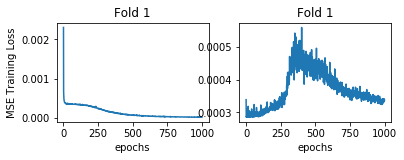

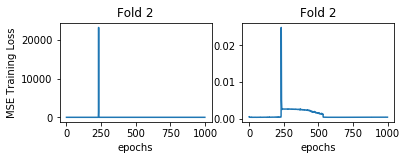

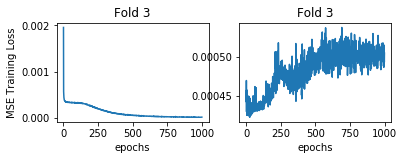

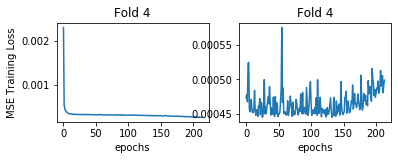

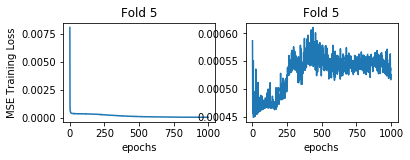

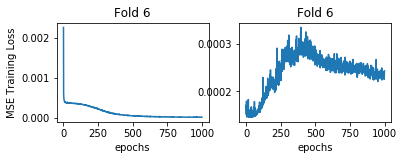

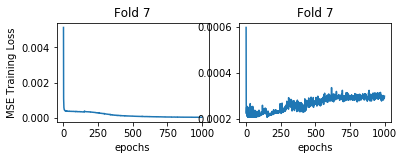

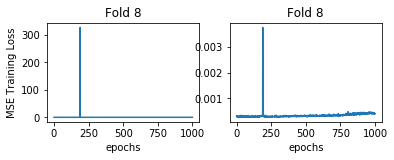

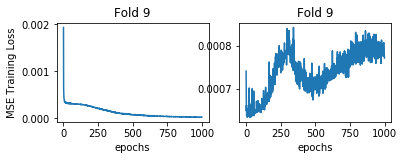

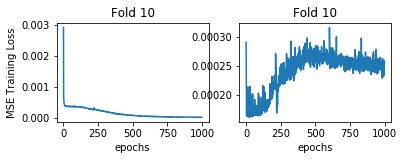

In [14]:
from matplotlib import pyplot as plt

for i,history in enumerate(historiesLSTM):
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.title("Fold " + str(i+1))
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.title("Fold " + str(i+1))

    plt.xlabel('epochs')
    plt.show()

# GRU

In [11]:
from keras.layers import LSTM, Lambda, Dropout,GRU
from keras import optimizers
from sklearn.model_selection import KFold


kfold = KFold(n_splits=10, shuffle=True, random_state=None)
# fit model
historiesGRU = []
# scores = []

k = 1
# for train_index, test_index in kfold.split(xtime, ytarget):
gruModels=[]
for train_index, test_index in kfold.split(xtime, ytarget):
    gru = Sequential()
    gru.add(GRU(100,dropout=.2,activation='relu', input_shape=(90, 35), return_sequences=True))
    gru.add(Lambda(lambda x: x[:, -predictedDays:, :]))
    gru.add(Dense(1))

    gru.summary()
#     adm = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    gru.compile(optimizer='adam', loss='mse')
    print("Fold: ", k)
    x_train, x_test = xtime[train_index], xtime[test_index]
    y_train, y_test = ytarget[train_index], ytarget[test_index]
    y_train = y_train.reshape(y_train.shape[0],14,1)
    y_test= y_test.reshape(y_test.shape[0],14,1)
    
    historiesGRU.append(gru.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=1000, verbose=1))
    gruModels.append(gru)
    k += 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 90, 100)           40800     
_________________________________________________________________
lambda_7 (Lambda)            (None, 14, 100)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 14, 1)             101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Fold:  1
Train on 1528 samples, validate on 170 samples
Epoch 1/1000
1528/1528 [==============================] - 5s 3ms/step - loss: 0.0056 - val_loss: 5.4998e-04
Epoch 2/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 0.0012 - val_loss: 4.2092e-04
Epoch 3/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 8.6372e-04 - val_loss: 5.6987e-04
Epoch 4/1000
1528/

1528/1528 [==============================] - 4s 3ms/step - loss: 3.4497e-04 - val_loss: 3.2905e-04
Epoch 67/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.4364e-04 - val_loss: 3.3598e-04
Epoch 68/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.4266e-04 - val_loss: 3.2121e-04
Epoch 69/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.4179e-04 - val_loss: 3.5493e-04
Epoch 70/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.5445e-04 - val_loss: 3.4088e-04
Epoch 71/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.5123e-04 - val_loss: 3.9455e-04
Epoch 72/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.4102e-04 - val_loss: 3.2457e-04
Epoch 73/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3870e-04 - val_loss: 3.2197e-04
Epoch 74/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.5572e-04 - val_loss: 3.1657e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.1581e-04 - val_loss: 3.1933e-04
Epoch 139/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2161e-04 - val_loss: 3.0437e-04
Epoch 140/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1337e-04 - val_loss: 3.0372e-04
Epoch 141/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1632e-04 - val_loss: 2.9658e-04
Epoch 142/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1261e-04 - val_loss: 2.9456e-04
Epoch 143/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3103e-04 - val_loss: 3.2156e-04
Epoch 144/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2088e-04 - val_loss: 2.9691e-04
Epoch 145/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.4191e-04 - val_loss: 3.3309e-04
Epoch 146/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.1617e-04 - val_loss: 

Epoch 210/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.5345e-04 - val_loss: 2.5239e-04
Epoch 211/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6702e-04 - val_loss: 4.0715e-04
Epoch 212/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.6833e-04 - val_loss: 2.4150e-04
Epoch 213/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.5561e-04 - val_loss: 2.5852e-04
Epoch 214/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.6587e-04 - val_loss: 2.9686e-04
Epoch 215/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.5594e-04 - val_loss: 2.4831e-04
Epoch 216/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.5640e-04 - val_loss: 2.4733e-04
Epoch 217/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.5158e-04 - val_loss: 2.3471e-04
Epoch 218/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.5864e-

Epoch 282/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.1071e-04 - val_loss: 1.9544e-04
Epoch 283/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0619e-04 - val_loss: 1.8861e-04
Epoch 284/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.0615e-04 - val_loss: 1.8873e-04
Epoch 285/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.0393e-04 - val_loss: 1.7928e-04
Epoch 286/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.0253e-04 - val_loss: 1.8319e-04
Epoch 287/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.9962e-04 - val_loss: 1.8064e-04
Epoch 288/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.0266e-04 - val_loss: 1.8254e-04
Epoch 289/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.0139e-04 - val_loss: 2.3010e-04
Epoch 290/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.0575e-

Epoch 354/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.5221e-04 - val_loss: 1.1810e-04
Epoch 355/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.4728e-04 - val_loss: 1.1969e-04
Epoch 356/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.4682e-04 - val_loss: 1.1953e-04
Epoch 357/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.4461e-04 - val_loss: 1.3610e-04
Epoch 358/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4888e-04 - val_loss: 1.1723e-04
Epoch 359/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.4485e-04 - val_loss: 1.1430e-04
Epoch 360/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.4468e-04 - val_loss: 1.2226e-04
Epoch 361/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4605e-04 - val_loss: 1.0962e-04
Epoch 362/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.4028e-

1528/1528 [==============================] - 3s 2ms/step - loss: 1.0641e-04 - val_loss: 9.0510e-05
Epoch 426/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1036e-04 - val_loss: 6.8663e-05
Epoch 427/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0037e-04 - val_loss: 6.9954e-05
Epoch 428/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0163e-04 - val_loss: 6.9437e-05
Epoch 429/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0713e-04 - val_loss: 6.7925e-05
Epoch 430/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0328e-04 - val_loss: 7.0397e-05
Epoch 431/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0198e-04 - val_loss: 8.8929e-05
Epoch 432/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0108e-04 - val_loss: 6.6335e-05
Epoch 433/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0132e-04 - val_loss: 

Epoch 497/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6350e-05 - val_loss: 6.3878e-05
Epoch 498/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.9927e-05 - val_loss: 4.7265e-05
Epoch 499/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.4677e-05 - val_loss: 4.6999e-05
Epoch 500/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6371e-05 - val_loss: 5.4782e-05
Epoch 501/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6315e-05 - val_loss: 4.9669e-05
Epoch 502/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.8589e-05 - val_loss: 6.4767e-05
Epoch 503/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6430e-05 - val_loss: 6.1542e-05
Epoch 504/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.2225e-05 - val_loss: 6.6293e-05
Epoch 505/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.5958e-

Epoch 569/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.9671e-05 - val_loss: 3.8057e-05
Epoch 570/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 6.1876e-05 - val_loss: 3.5833e-05
Epoch 571/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 6.1128e-05 - val_loss: 3.5494e-05
Epoch 572/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 6.2249e-05 - val_loss: 3.5468e-05
Epoch 573/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 6.8229e-05 - val_loss: 4.1674e-05
Epoch 574/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 6.2329e-05 - val_loss: 3.1329e-05
Epoch 575/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 7.1858e-05 - val_loss: 8.9533e-05
Epoch 576/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 6.7175e-05 - val_loss: 3.3864e-05
Epoch 577/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.9883e-

Epoch 641/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.1715e-05 - val_loss: 2.7145e-05
Epoch 642/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4046e-05 - val_loss: 2.4127e-05
Epoch 643/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.8351e-05 - val_loss: 2.6720e-05
Epoch 644/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1478e-05 - val_loss: 3.7744e-05
Epoch 645/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.2324e-05 - val_loss: 2.6600e-05
Epoch 646/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.5560e-05 - val_loss: 3.5634e-05
Epoch 647/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.8948e-05 - val_loss: 3.6612e-05
Epoch 648/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.8886e-05 - val_loss: 2.5763e-05
Epoch 649/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.0476e-

Epoch 713/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.6376e-05 - val_loss: 3.1978e-05
Epoch 714/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.5821e-05 - val_loss: 1.9291e-05
Epoch 715/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.2865e-05 - val_loss: 2.0751e-05
Epoch 716/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.4882e-05 - val_loss: 1.9159e-05
Epoch 717/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.5453e-05 - val_loss: 2.6327e-05
Epoch 718/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.3602e-05 - val_loss: 2.0650e-05
Epoch 719/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.0389e-05 - val_loss: 2.1045e-05
Epoch 720/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.1050e-05 - val_loss: 2.0238e-05
Epoch 721/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 4.1157e-

Epoch 785/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6378e-05 - val_loss: 2.0448e-05
Epoch 786/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.6506e-05 - val_loss: 1.9162e-05
Epoch 787/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.8473e-05 - val_loss: 3.8484e-05
Epoch 788/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.8472e-05 - val_loss: 1.4806e-05
Epoch 789/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.4968e-05 - val_loss: 1.5057e-05
Epoch 790/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.6005e-05 - val_loss: 1.7106e-05
Epoch 791/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.7616e-05 - val_loss: 1.4594e-05
Epoch 792/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.2979e-05 - val_loss: 1.4350e-05
Epoch 793/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.4533e-

Epoch 857/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9921e-05 - val_loss: 1.5904e-05
Epoch 858/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8306e-05 - val_loss: 1.5572e-05
Epoch 859/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4101e-05 - val_loss: 1.7292e-05
Epoch 860/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9669e-05 - val_loss: 1.4482e-05
Epoch 861/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8628e-05 - val_loss: 1.2382e-05
Epoch 862/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9374e-05 - val_loss: 1.3343e-05
Epoch 863/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1208e-05 - val_loss: 1.1928e-05
Epoch 864/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9966e-05 - val_loss: 1.2609e-05
Epoch 865/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3979e-

Epoch 929/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2381e-05 - val_loss: 1.3488e-05
Epoch 930/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7496e-05 - val_loss: 1.0287e-05
Epoch 931/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.5925e-05 - val_loss: 1.2779e-05
Epoch 932/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2036e-05 - val_loss: 1.1966e-05
Epoch 933/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.7059e-05 - val_loss: 1.1448e-05
Epoch 934/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7870e-05 - val_loss: 2.3029e-05
Epoch 935/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8199e-05 - val_loss: 1.2869e-05
Epoch 936/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6908e-05 - val_loss: 1.0016e-05
Epoch 937/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6731e-

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 90, 100)           40800     
_________________________________________________________________
lambda_8 (Lambda)            (None, 14, 100)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 14, 1)             101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Fold:  2
Train on 1528 samples, validate on 170 samples
Epoch 1/1000
1528/1528 [==============================] - 5s 3ms/step - loss: 0.0033 - val_loss: 3.9765e-04
Epoch 2/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 8.6656e-04 - val_loss: 3.6603e-04
Epoch 3/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 6.2294e-04 - val_loss: 3.6470e-04
Epoch 4/1000
1

1528/1528 [==============================] - 3s 2ms/step - loss: 3.4818e-04 - val_loss: 3.2968e-04
Epoch 67/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4946e-04 - val_loss: 3.5172e-04
Epoch 68/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4586e-04 - val_loss: 3.2553e-04
Epoch 69/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5323e-04 - val_loss: 3.2693e-04
Epoch 70/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7955e-04 - val_loss: 3.2879e-04
Epoch 71/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8368e-04 - val_loss: 3.6093e-04
Epoch 72/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4669e-04 - val_loss: 3.3618e-04
Epoch 73/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4299e-04 - val_loss: 3.2468e-04
Epoch 74/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7148e-04 - val_loss: 3.3266e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.3402e-04 - val_loss: 3.2906e-04
Epoch 139/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3785e-04 - val_loss: 3.5154e-04
Epoch 140/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3964e-04 - val_loss: 3.6352e-04
Epoch 141/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4632e-04 - val_loss: 3.1226e-04
Epoch 142/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2757e-04 - val_loss: 3.1213e-04
Epoch 143/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2788e-04 - val_loss: 3.2944e-04
Epoch 144/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3602e-04 - val_loss: 3.1178e-04
Epoch 145/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5137e-04 - val_loss: 3.2385e-04
Epoch 146/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3844e-04 - val_loss: 

Epoch 210/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9023e-04 - val_loss: 2.6742e-04
Epoch 211/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.9286e-04 - val_loss: 2.6732e-04
Epoch 212/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8303e-04 - val_loss: 2.6784e-04
Epoch 213/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9241e-04 - val_loss: 3.0124e-04
Epoch 214/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0055e-04 - val_loss: 2.6775e-04
Epoch 215/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8274e-04 - val_loss: 2.8472e-04
Epoch 216/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0550e-04 - val_loss: 2.9190e-04
Epoch 217/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1835e-04 - val_loss: 2.6124e-04
Epoch 218/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8047e-

Epoch 282/1000
1528/1528 [==============================] - 5s 3ms/step - loss: 2.2741e-04 - val_loss: 2.0990e-04
Epoch 283/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.3880e-04 - val_loss: 2.1349e-04
Epoch 284/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.2317e-04 - val_loss: 2.0191e-04
Epoch 285/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.4523e-04 - val_loss: 2.9073e-04
Epoch 286/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.4681e-04 - val_loss: 2.1967e-04
Epoch 287/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.2120e-04 - val_loss: 2.0330e-04
Epoch 288/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 2.2553e-04 - val_loss: 2.2510e-04
Epoch 289/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.2466e-04 - val_loss: 2.0116e-04
Epoch 290/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 2.2984e-

Epoch 354/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9239e-04 - val_loss: 1.6439e-04
Epoch 355/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9430e-04 - val_loss: 1.5951e-04
Epoch 356/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9598e-04 - val_loss: 1.6529e-04
Epoch 357/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.7694e-04 - val_loss: 1.6176e-04
Epoch 358/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.9214e-04 - val_loss: 1.6752e-04
Epoch 359/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.8075e-04 - val_loss: 1.7931e-04
Epoch 360/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.8369e-04 - val_loss: 1.7354e-04
Epoch 361/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.8323e-04 - val_loss: 1.6088e-04
Epoch 362/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.7746e-

Epoch 426/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 1.4992e-04 - val_loss: 1.1893e-04
Epoch 427/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 1.4499e-04 - val_loss: 1.2615e-04
Epoch 428/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 1.4642e-04 - val_loss: 1.4682e-04
Epoch 429/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 1.4996e-04 - val_loss: 1.2431e-04
Epoch 430/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 1.4488e-04 - val_loss: 1.3575e-04
Epoch 431/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 1.5239e-04 - val_loss: 1.2209e-04
Epoch 432/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 1.4807e-04 - val_loss: 1.1031e-04
Epoch 433/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 1.5374e-04 - val_loss: 1.1940e-04
Epoch 434/1000
1528/1528 [==============================] - 4s 3ms/step - loss: 1.5025e-

Epoch 498/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.1431e-04 - val_loss: 9.0750e-05
Epoch 499/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.2189e-04 - val_loss: 9.3270e-05
Epoch 500/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1181e-04 - val_loss: 8.4137e-05
Epoch 501/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.1736e-04 - val_loss: 9.6304e-05
Epoch 502/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.1463e-04 - val_loss: 9.7433e-05
Epoch 503/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.2830e-04 - val_loss: 8.7354e-05
Epoch 504/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.1337e-04 - val_loss: 9.6619e-05
Epoch 505/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.2575e-04 - val_loss: 1.2990e-04
Epoch 506/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.1333e-

Epoch 570/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.0071e-04 - val_loss: 7.3083e-05
Epoch 571/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 9.4772e-05 - val_loss: 8.7907e-05
Epoch 572/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 9.0942e-05 - val_loss: 7.3352e-05
Epoch 573/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 9.4248e-05 - val_loss: 7.9174e-05
Epoch 574/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 9.5469e-05 - val_loss: 7.0722e-05
Epoch 575/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.0476e-04 - val_loss: 1.2204e-04
Epoch 576/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 1.1445e-04 - val_loss: 7.4360e-05
Epoch 577/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 9.6849e-05 - val_loss: 8.5337e-05
Epoch 578/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 9.0357e-

Epoch 642/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.2133e-05 - val_loss: 6.4853e-05
Epoch 643/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.9658e-05 - val_loss: 8.6970e-05
Epoch 644/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2809e-05 - val_loss: 5.4759e-05
Epoch 645/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.8993e-05 - val_loss: 5.7115e-05
Epoch 646/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.5695e-05 - val_loss: 5.4459e-05
Epoch 647/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.8805e-05 - val_loss: 4.8071e-05
Epoch 648/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2074e-05 - val_loss: 4.9688e-05
Epoch 649/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0844e-05 - val_loss: 4.8596e-05
Epoch 650/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.7455e-

Epoch 714/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.1186e-05 - val_loss: 4.7593e-05
Epoch 715/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.3391e-05 - val_loss: 5.0856e-05
Epoch 716/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.3168e-05 - val_loss: 4.2078e-05
Epoch 717/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8474e-05 - val_loss: 4.0315e-05
Epoch 718/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0339e-05 - val_loss: 3.9095e-05
Epoch 719/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0021e-05 - val_loss: 4.2072e-05
Epoch 720/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.2216e-05 - val_loss: 4.2562e-05
Epoch 721/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.1013e-05 - val_loss: 4.3372e-05
Epoch 722/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0124e-

Epoch 786/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9608e-05 - val_loss: 4.1193e-05
Epoch 787/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8175e-05 - val_loss: 3.5920e-05
Epoch 788/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7717e-05 - val_loss: 3.7852e-05
Epoch 789/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4761e-05 - val_loss: 3.2718e-05
Epoch 790/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6769e-05 - val_loss: 3.3352e-05
Epoch 791/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7643e-05 - val_loss: 3.3547e-05
Epoch 792/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4248e-05 - val_loss: 4.8999e-05
Epoch 793/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7290e-05 - val_loss: 4.5049e-05
Epoch 794/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1194e-

Epoch 858/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0947e-05 - val_loss: 4.2396e-05
Epoch 859/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7388e-05 - val_loss: 4.7566e-05
Epoch 860/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8786e-05 - val_loss: 3.1329e-05
Epoch 861/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4604e-05 - val_loss: 3.1275e-05
Epoch 862/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5389e-05 - val_loss: 2.6939e-05
Epoch 863/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0084e-05 - val_loss: 3.7942e-05
Epoch 864/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8502e-05 - val_loss: 4.0779e-05
Epoch 865/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6322e-05 - val_loss: 2.6881e-05
Epoch 866/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2647e-

Epoch 930/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9291e-05 - val_loss: 4.4080e-05
Epoch 931/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9963e-05 - val_loss: 2.3005e-05
Epoch 932/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7452e-05 - val_loss: 2.6848e-05
Epoch 933/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7205e-05 - val_loss: 2.6139e-05
Epoch 934/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9572e-05 - val_loss: 2.4332e-05
Epoch 935/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0322e-05 - val_loss: 2.6564e-05
Epoch 936/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7670e-05 - val_loss: 3.2878e-05
Epoch 937/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0133e-05 - val_loss: 2.8443e-05
Epoch 938/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5721e-

Train on 1528 samples, validate on 170 samples
Epoch 1/1000
1528/1528 [==============================] - 5s 3ms/step - loss: 0.0024 - val_loss: 6.1237e-04
Epoch 2/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 7.7591e-04 - val_loss: 3.4423e-04
Epoch 3/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 5.8919e-04 - val_loss: 3.3091e-04
Epoch 4/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9326e-04 - val_loss: 3.3085e-04
Epoch 5/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4635e-04 - val_loss: 3.2222e-04
Epoch 6/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1756e-04 - val_loss: 3.6106e-04
Epoch 7/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8817e-04 - val_loss: 3.1717e-04
Epoch 8/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8728e-04 - val_loss: 3.2046e-04
Epoch 9/1000
1528/1528 [==============================] - 3s 

1528/1528 [==============================] - 4s 2ms/step - loss: 3.4515e-04 - val_loss: 3.2801e-04
Epoch 74/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4213e-04 - val_loss: 3.0203e-04
Epoch 75/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3891e-04 - val_loss: 3.0552e-04
Epoch 76/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3698e-04 - val_loss: 2.9954e-04
Epoch 77/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3661e-04 - val_loss: 3.0062e-04
Epoch 78/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4009e-04 - val_loss: 3.0180e-04
Epoch 79/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.4012e-04 - val_loss: 3.0030e-04
Epoch 80/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3873e-04 - val_loss: 3.0343e-04
Epoch 81/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.3871e-04 - val_loss: 3.0037e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.1785e-04 - val_loss: 2.8701e-04
Epoch 146/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2612e-04 - val_loss: 2.7708e-04
Epoch 147/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1827e-04 - val_loss: 3.0181e-04
Epoch 148/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2931e-04 - val_loss: 2.7578e-04
Epoch 149/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.2094e-04 - val_loss: 3.1105e-04
Epoch 150/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.2136e-04 - val_loss: 2.7010e-04
Epoch 151/1000
1528/1528 [==============================] - 4s 2ms/step - loss: 3.1792e-04 - val_loss: 2.7418e-04
Epoch 152/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1561e-04 - val_loss: 2.6973e-04
Epoch 153/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1751e-04 - val_loss: 

Epoch 217/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5080e-04 - val_loss: 1.9185e-04
Epoch 218/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5484e-04 - val_loss: 1.9177e-04
Epoch 219/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5346e-04 - val_loss: 1.9521e-04
Epoch 220/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4733e-04 - val_loss: 2.0163e-04
Epoch 221/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5358e-04 - val_loss: 1.9027e-04
Epoch 222/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5221e-04 - val_loss: 1.9840e-04
Epoch 223/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4941e-04 - val_loss: 2.1260e-04
Epoch 224/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4726e-04 - val_loss: 1.9737e-04
Epoch 225/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4228e-

Epoch 289/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8538e-04 - val_loss: 1.4061e-04
Epoch 290/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8942e-04 - val_loss: 1.4617e-04
Epoch 291/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8351e-04 - val_loss: 1.2382e-04
Epoch 292/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8344e-04 - val_loss: 1.3131e-04
Epoch 293/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9305e-04 - val_loss: 1.3526e-04
Epoch 294/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8555e-04 - val_loss: 1.2950e-04
Epoch 295/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8259e-04 - val_loss: 1.3170e-04
Epoch 296/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8419e-04 - val_loss: 1.2788e-04
Epoch 297/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7864e-

Epoch 361/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3775e-04 - val_loss: 1.0450e-04
Epoch 362/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3679e-04 - val_loss: 9.9286e-05
Epoch 363/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3703e-04 - val_loss: 9.7452e-05
Epoch 364/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3859e-04 - val_loss: 1.0029e-04
Epoch 365/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3806e-04 - val_loss: 1.0424e-04
Epoch 366/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3730e-04 - val_loss: 1.1368e-04
Epoch 367/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3954e-04 - val_loss: 1.0628e-04
Epoch 368/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3597e-04 - val_loss: 1.2572e-04
Epoch 369/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3309e-

Epoch 433/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0657e-04 - val_loss: 8.0322e-05
Epoch 434/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0790e-04 - val_loss: 7.7169e-05
Epoch 435/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0734e-04 - val_loss: 8.8437e-05
Epoch 436/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0889e-04 - val_loss: 7.3117e-05
Epoch 437/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0462e-04 - val_loss: 7.4955e-05
Epoch 438/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0300e-04 - val_loss: 7.4389e-05
Epoch 439/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0534e-04 - val_loss: 7.6001e-05
Epoch 440/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0884e-04 - val_loss: 7.2329e-05
Epoch 441/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0612e-

Epoch 505/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.5148e-05 - val_loss: 6.6485e-05
Epoch 506/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.7730e-05 - val_loss: 6.3335e-05
Epoch 507/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.7466e-05 - val_loss: 6.4519e-05
Epoch 508/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.3950e-05 - val_loss: 7.0694e-05
Epoch 509/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.3392e-05 - val_loss: 6.1749e-05
Epoch 510/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.5354e-05 - val_loss: 5.6514e-05
Epoch 511/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.2229e-05 - val_loss: 6.0316e-05
Epoch 512/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.2643e-05 - val_loss: 5.3707e-05
Epoch 513/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.4691e-

Epoch 577/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9990e-05 - val_loss: 4.2940e-05
Epoch 578/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7988e-05 - val_loss: 5.0213e-05
Epoch 579/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9218e-05 - val_loss: 5.6010e-05
Epoch 580/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7359e-05 - val_loss: 7.7590e-05
Epoch 581/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8553e-05 - val_loss: 4.5560e-05
Epoch 582/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.6937e-05 - val_loss: 5.0639e-05
Epoch 583/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.6997e-05 - val_loss: 5.3634e-05
Epoch 584/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0210e-05 - val_loss: 5.6563e-05
Epoch 585/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8268e-

Epoch 649/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.9062e-05 - val_loss: 5.7169e-05
Epoch 650/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0908e-05 - val_loss: 3.3226e-05
Epoch 651/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4776e-05 - val_loss: 3.9645e-05
Epoch 652/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.9927e-05 - val_loss: 3.6329e-05
Epoch 653/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5614e-05 - val_loss: 3.5505e-05
Epoch 654/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4202e-05 - val_loss: 3.7087e-05
Epoch 655/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5940e-05 - val_loss: 4.1523e-05
Epoch 656/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6833e-05 - val_loss: 3.6430e-05
Epoch 657/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6210e-

Epoch 721/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1183e-05 - val_loss: 2.9140e-05
Epoch 722/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2244e-05 - val_loss: 2.7513e-05
Epoch 723/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6402e-05 - val_loss: 3.1365e-05
Epoch 724/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7329e-05 - val_loss: 3.1758e-05
Epoch 725/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6726e-05 - val_loss: 2.9528e-05
Epoch 726/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4498e-05 - val_loss: 3.4093e-05
Epoch 727/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7387e-05 - val_loss: 2.9057e-05
Epoch 728/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0863e-05 - val_loss: 3.9787e-05
Epoch 729/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1116e-

Epoch 793/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1588e-05 - val_loss: 2.5884e-05
Epoch 794/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1001e-05 - val_loss: 2.8524e-05
Epoch 795/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2084e-05 - val_loss: 2.6821e-05
Epoch 796/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2091e-05 - val_loss: 2.6538e-05
Epoch 797/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0230e-05 - val_loss: 2.4531e-05
Epoch 798/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0532e-05 - val_loss: 2.8440e-05
Epoch 799/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2656e-05 - val_loss: 2.9366e-05
Epoch 800/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3482e-05 - val_loss: 2.7605e-05
Epoch 801/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1343e-

Epoch 865/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1303e-05 - val_loss: 2.0691e-05
Epoch 866/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5315e-05 - val_loss: 2.1883e-05
Epoch 867/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9041e-05 - val_loss: 2.1451e-05
Epoch 868/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6297e-05 - val_loss: 2.1019e-05
Epoch 869/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9142e-05 - val_loss: 2.0523e-05
Epoch 870/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7121e-05 - val_loss: 2.2549e-05
Epoch 871/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6956e-05 - val_loss: 2.2363e-05
Epoch 872/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4741e-05 - val_loss: 2.7704e-05
Epoch 873/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6473e-

Epoch 937/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3144e-05 - val_loss: 2.2633e-05
Epoch 938/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3063e-05 - val_loss: 2.0217e-05
Epoch 939/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2583e-05 - val_loss: 2.1626e-05
Epoch 940/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3725e-05 - val_loss: 2.2525e-05
Epoch 941/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1727e-05 - val_loss: 3.9460e-05
Epoch 942/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4218e-05 - val_loss: 1.9181e-05
Epoch 943/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6939e-05 - val_loss: 1.8453e-05
Epoch 944/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3157e-05 - val_loss: 1.7318e-05
Epoch 945/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3820e-

1528/1528 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 4.2645e-04
Epoch 3/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.4487e-04 - val_loss: 4.7207e-04
Epoch 4/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7137e-04 - val_loss: 4.4446e-04
Epoch 5/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.1882e-04 - val_loss: 5.5595e-04
Epoch 6/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4009e-04 - val_loss: 5.0421e-04
Epoch 7/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8947e-04 - val_loss: 3.7627e-04
Epoch 8/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5442e-04 - val_loss: 3.6953e-04
Epoch 9/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6293e-04 - val_loss: 4.3060e-04
Epoch 10/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3158e-04 - val_loss: 3.7280e-04
Epoch 11

1528/1528 [==============================] - 3s 2ms/step - loss: 3.4429e-04 - val_loss: 3.3310e-04
Epoch 75/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7495e-04 - val_loss: 3.8950e-04
Epoch 76/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7077e-04 - val_loss: 3.2768e-04
Epoch 77/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3751e-04 - val_loss: 3.2386e-04
Epoch 78/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4908e-04 - val_loss: 3.6932e-04
Epoch 79/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4480e-04 - val_loss: 3.2673e-04
Epoch 80/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3429e-04 - val_loss: 3.3599e-04
Epoch 81/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5287e-04 - val_loss: 3.2447e-04
Epoch 82/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4980e-04 - val_loss: 3.9491e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.5179e-04 - val_loss: 3.1569e-04
Epoch 147/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3694e-04 - val_loss: 3.1401e-04
Epoch 148/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3435e-04 - val_loss: 3.3882e-04
Epoch 149/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3283e-04 - val_loss: 3.1657e-04
Epoch 150/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3064e-04 - val_loss: 3.1958e-04
Epoch 151/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3191e-04 - val_loss: 3.1706e-04
Epoch 152/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2493e-04 - val_loss: 3.2901e-04
Epoch 153/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2574e-04 - val_loss: 3.1377e-04
Epoch 154/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1915e-04 - val_loss: 

Epoch 218/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8914e-04 - val_loss: 2.7983e-04
Epoch 219/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8904e-04 - val_loss: 2.7520e-04
Epoch 220/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9191e-04 - val_loss: 2.8904e-04
Epoch 221/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0369e-04 - val_loss: 2.7872e-04
Epoch 222/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9838e-04 - val_loss: 2.8429e-04
Epoch 223/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8370e-04 - val_loss: 2.7753e-04
Epoch 224/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9775e-04 - val_loss: 2.7767e-04
Epoch 225/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9144e-04 - val_loss: 2.7498e-04
Epoch 226/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8810e-

Epoch 290/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4970e-04 - val_loss: 2.1988e-04
Epoch 291/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4529e-04 - val_loss: 2.3737e-04
Epoch 292/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3569e-04 - val_loss: 2.2763e-04
Epoch 293/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4064e-04 - val_loss: 2.2815e-04
Epoch 294/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4263e-04 - val_loss: 2.4591e-04
Epoch 295/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3579e-04 - val_loss: 2.3280e-04
Epoch 296/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4337e-04 - val_loss: 2.2845e-04
Epoch 297/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3512e-04 - val_loss: 2.4008e-04
Epoch 298/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4285e-

Epoch 362/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0330e-04 - val_loss: 1.8514e-04
Epoch 363/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0781e-04 - val_loss: 2.1437e-04
Epoch 364/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0374e-04 - val_loss: 1.7796e-04
Epoch 365/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9559e-04 - val_loss: 1.7808e-04
Epoch 366/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9292e-04 - val_loss: 1.8654e-04
Epoch 367/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9084e-04 - val_loss: 1.9246e-04
Epoch 368/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9618e-04 - val_loss: 1.7754e-04
Epoch 369/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8549e-04 - val_loss: 1.7756e-04
Epoch 370/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0199e-

Epoch 434/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5281e-04 - val_loss: 1.3339e-04
Epoch 435/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5437e-04 - val_loss: 1.3411e-04
Epoch 436/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5054e-04 - val_loss: 1.4884e-04
Epoch 437/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5068e-04 - val_loss: 1.3508e-04
Epoch 438/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4908e-04 - val_loss: 1.4666e-04
Epoch 439/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5275e-04 - val_loss: 1.3413e-04
Epoch 440/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6107e-04 - val_loss: 1.7796e-04
Epoch 441/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5410e-04 - val_loss: 1.2554e-04
Epoch 442/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4470e-

Epoch 506/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2759e-04 - val_loss: 1.3580e-04
Epoch 507/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2194e-04 - val_loss: 1.0303e-04
Epoch 508/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1714e-04 - val_loss: 9.6092e-05
Epoch 509/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1690e-04 - val_loss: 9.9303e-05
Epoch 510/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2081e-04 - val_loss: 1.0195e-04
Epoch 511/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1489e-04 - val_loss: 9.5303e-05
Epoch 512/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1659e-04 - val_loss: 9.8245e-05
Epoch 513/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1014e-04 - val_loss: 9.2771e-05
Epoch 514/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1192e-

Epoch 578/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.7681e-05 - val_loss: 9.3577e-05
Epoch 579/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.9005e-05 - val_loss: 7.8368e-05
Epoch 580/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.1762e-05 - val_loss: 7.3552e-05
Epoch 581/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.6161e-05 - val_loss: 7.9264e-05
Epoch 582/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.7992e-05 - val_loss: 7.7337e-05
Epoch 583/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.0426e-05 - val_loss: 8.4824e-05
Epoch 584/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.5116e-05 - val_loss: 8.7425e-05
Epoch 585/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.3725e-05 - val_loss: 8.0714e-05
Epoch 586/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.8981e-

Epoch 650/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.0630e-05 - val_loss: 6.4350e-05
Epoch 651/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.7855e-05 - val_loss: 6.5060e-05
Epoch 652/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.4703e-05 - val_loss: 7.3169e-05
Epoch 653/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.9954e-05 - val_loss: 6.5961e-05
Epoch 654/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.9094e-05 - val_loss: 6.4420e-05
Epoch 655/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.4997e-05 - val_loss: 6.4355e-05
Epoch 656/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.3349e-05 - val_loss: 7.1675e-05
Epoch 657/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6968e-05 - val_loss: 6.8063e-05
Epoch 658/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.7628e-

Epoch 722/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7857e-05 - val_loss: 6.7065e-05
Epoch 723/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0566e-05 - val_loss: 6.8334e-05
Epoch 724/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8999e-05 - val_loss: 5.6763e-05
Epoch 725/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.6542e-05 - val_loss: 5.3504e-05
Epoch 726/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.6407e-05 - val_loss: 5.9402e-05
Epoch 727/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7895e-05 - val_loss: 5.9756e-05
Epoch 728/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6658e-05 - val_loss: 6.9063e-05
Epoch 729/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.4747e-05 - val_loss: 5.4637e-05
Epoch 730/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.3808e-

Epoch 794/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8060e-05 - val_loss: 5.3853e-05
Epoch 795/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.9469e-05 - val_loss: 5.1666e-05
Epoch 796/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.9330e-05 - val_loss: 5.5765e-05
Epoch 797/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7131e-05 - val_loss: 5.3431e-05
Epoch 798/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5408e-05 - val_loss: 5.1403e-05
Epoch 799/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6578e-05 - val_loss: 5.9102e-05
Epoch 800/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7266e-05 - val_loss: 5.3051e-05
Epoch 801/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.2308e-05 - val_loss: 5.1677e-05
Epoch 802/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6490e-

Epoch 866/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1226e-05 - val_loss: 5.5285e-05
Epoch 867/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4100e-05 - val_loss: 4.8130e-05
Epoch 868/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9178e-05 - val_loss: 4.0685e-05
Epoch 869/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1807e-05 - val_loss: 5.1047e-05
Epoch 870/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9779e-05 - val_loss: 3.8931e-05
Epoch 871/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0948e-05 - val_loss: 3.8342e-05
Epoch 872/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1840e-05 - val_loss: 4.8697e-05
Epoch 873/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9345e-05 - val_loss: 6.1588e-05
Epoch 874/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3440e-

Epoch 938/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4597e-05 - val_loss: 4.0180e-05
Epoch 939/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6273e-05 - val_loss: 4.9762e-05
Epoch 940/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3038e-05 - val_loss: 3.9616e-05
Epoch 941/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4761e-05 - val_loss: 3.8867e-05
Epoch 942/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4288e-05 - val_loss: 4.4092e-05
Epoch 943/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4726e-05 - val_loss: 3.8219e-05
Epoch 944/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5107e-05 - val_loss: 5.3825e-05
Epoch 945/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9678e-05 - val_loss: 4.4918e-05
Epoch 946/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4186e-

1528/1528 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 4.7423e-04
Epoch 4/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.0727e-04 - val_loss: 8.1001e-04
Epoch 5/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.3320e-04 - val_loss: 5.0295e-04
Epoch 6/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2277e-04 - val_loss: 4.5973e-04
Epoch 7/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0457e-04 - val_loss: 4.1170e-04
Epoch 8/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8108e-04 - val_loss: 3.5607e-04
Epoch 9/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4632e-04 - val_loss: 3.6624e-04
Epoch 10/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8014e-04 - val_loss: 4.0093e-04
Epoch 11/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5713e-04 - val_loss: 3.5214e-04
Epoch 1

1528/1528 [==============================] - 3s 2ms/step - loss: 3.4202e-04 - val_loss: 3.2904e-04
Epoch 76/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3963e-04 - val_loss: 3.2711e-04
Epoch 77/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4001e-04 - val_loss: 3.3287e-04
Epoch 78/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4958e-04 - val_loss: 3.3468e-04
Epoch 79/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5089e-04 - val_loss: 3.2679e-04
Epoch 80/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3678e-04 - val_loss: 3.2690e-04
Epoch 81/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3697e-04 - val_loss: 3.2628e-04
Epoch 82/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4292e-04 - val_loss: 3.4036e-04
Epoch 83/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4034e-04 - val_loss: 3.2547e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.3446e-04 - val_loss: 3.2432e-04
Epoch 148/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3902e-04 - val_loss: 3.1831e-04
Epoch 149/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2883e-04 - val_loss: 3.7360e-04
Epoch 150/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4654e-04 - val_loss: 3.3511e-04
Epoch 151/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3529e-04 - val_loss: 3.1539e-04
Epoch 152/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2957e-04 - val_loss: 3.1518e-04
Epoch 153/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3706e-04 - val_loss: 3.1872e-04
Epoch 154/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4769e-04 - val_loss: 4.2301e-04
Epoch 155/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5083e-04 - val_loss: 

Epoch 219/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1128e-04 - val_loss: 2.9924e-04
Epoch 220/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2165e-04 - val_loss: 2.9404e-04
Epoch 221/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1191e-04 - val_loss: 2.9402e-04
Epoch 222/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0672e-04 - val_loss: 2.9347e-04
Epoch 223/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0910e-04 - val_loss: 2.9243e-04
Epoch 224/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0396e-04 - val_loss: 2.9775e-04
Epoch 225/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0616e-04 - val_loss: 3.0266e-04
Epoch 226/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1389e-04 - val_loss: 2.9043e-04
Epoch 227/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0816e-

Epoch 291/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7854e-04 - val_loss: 2.4561e-04
Epoch 292/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7590e-04 - val_loss: 2.4586e-04
Epoch 293/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7087e-04 - val_loss: 2.4518e-04
Epoch 294/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6539e-04 - val_loss: 2.4497e-04
Epoch 295/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6371e-04 - val_loss: 2.4365e-04
Epoch 296/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6393e-04 - val_loss: 2.3748e-04
Epoch 297/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5996e-04 - val_loss: 2.4345e-04
Epoch 298/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6626e-04 - val_loss: 2.7879e-04
Epoch 299/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6718e-

Epoch 363/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2193e-04 - val_loss: 1.9366e-04
Epoch 364/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2273e-04 - val_loss: 1.9082e-04
Epoch 365/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2516e-04 - val_loss: 1.9221e-04
Epoch 366/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1821e-04 - val_loss: 1.9110e-04
Epoch 367/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1831e-04 - val_loss: 2.0350e-04
Epoch 368/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2543e-04 - val_loss: 1.9099e-04
Epoch 369/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1190e-04 - val_loss: 1.8445e-04
Epoch 370/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1787e-04 - val_loss: 2.1119e-04
Epoch 371/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1773e-

Epoch 435/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7926e-04 - val_loss: 1.6305e-04
Epoch 436/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8405e-04 - val_loss: 1.5170e-04
Epoch 437/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8866e-04 - val_loss: 1.5356e-04
Epoch 438/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8799e-04 - val_loss: 1.5002e-04
Epoch 439/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7698e-04 - val_loss: 1.4566e-04
Epoch 440/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7560e-04 - val_loss: 1.4744e-04
Epoch 441/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7572e-04 - val_loss: 1.4599e-04
Epoch 442/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7817e-04 - val_loss: 1.4756e-04
Epoch 443/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7719e-

Epoch 507/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3835e-04 - val_loss: 1.0746e-04
Epoch 508/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3928e-04 - val_loss: 1.0299e-04
Epoch 509/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4013e-04 - val_loss: 1.0672e-04
Epoch 510/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4911e-04 - val_loss: 1.1549e-04
Epoch 511/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4082e-04 - val_loss: 9.9473e-05
Epoch 512/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3706e-04 - val_loss: 9.6534e-05
Epoch 513/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3955e-04 - val_loss: 1.0237e-04
Epoch 514/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4279e-04 - val_loss: 1.0102e-04
Epoch 515/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4559e-

Epoch 579/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0685e-04 - val_loss: 8.3431e-05
Epoch 580/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0696e-04 - val_loss: 7.0263e-05
Epoch 581/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0577e-04 - val_loss: 7.1832e-05
Epoch 582/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0514e-04 - val_loss: 1.1193e-04
Epoch 583/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3139e-04 - val_loss: 7.4055e-05
Epoch 584/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0872e-04 - val_loss: 7.8242e-05
Epoch 585/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0856e-04 - val_loss: 6.8482e-05
Epoch 586/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0412e-04 - val_loss: 7.3072e-05
Epoch 587/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0477e-

Epoch 651/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.4496e-05 - val_loss: 6.0987e-05
Epoch 652/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.8971e-05 - val_loss: 6.1146e-05
Epoch 653/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.5834e-05 - val_loss: 5.3212e-05
Epoch 654/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.3538e-05 - val_loss: 5.6727e-05
Epoch 655/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.4207e-05 - val_loss: 5.0532e-05
Epoch 656/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.4728e-05 - val_loss: 5.7887e-05
Epoch 657/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.2994e-05 - val_loss: 5.4801e-05
Epoch 658/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.9673e-05 - val_loss: 8.3195e-05
Epoch 659/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.1410e-

Epoch 723/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6553e-05 - val_loss: 7.8602e-05
Epoch 724/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2978e-05 - val_loss: 3.9641e-05
Epoch 725/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7461e-05 - val_loss: 3.7852e-05
Epoch 726/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9424e-05 - val_loss: 4.2820e-05
Epoch 727/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6078e-05 - val_loss: 4.8077e-05
Epoch 728/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9134e-05 - val_loss: 3.9799e-05
Epoch 729/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.5449e-05 - val_loss: 4.2461e-05
Epoch 730/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.5354e-05 - val_loss: 4.3699e-05
Epoch 731/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8241e-

Epoch 795/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5229e-05 - val_loss: 2.9886e-05
Epoch 796/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7838e-05 - val_loss: 3.7163e-05
Epoch 797/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0043e-05 - val_loss: 4.9914e-05
Epoch 798/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.1833e-05 - val_loss: 3.4020e-05
Epoch 799/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6360e-05 - val_loss: 3.0528e-05
Epoch 800/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8933e-05 - val_loss: 3.4482e-05
Epoch 801/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4330e-05 - val_loss: 3.1358e-05
Epoch 802/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4017e-05 - val_loss: 2.8096e-05
Epoch 803/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3344e-

Epoch 867/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8369e-05 - val_loss: 3.5722e-05
Epoch 868/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9384e-05 - val_loss: 2.6938e-05
Epoch 869/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8477e-05 - val_loss: 4.2183e-05
Epoch 870/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1749e-05 - val_loss: 2.6391e-05
Epoch 871/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5760e-05 - val_loss: 2.6533e-05
Epoch 872/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6050e-05 - val_loss: 2.6412e-05
Epoch 873/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6172e-05 - val_loss: 2.7805e-05
Epoch 874/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6390e-05 - val_loss: 2.4429e-05
Epoch 875/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6283e-

Epoch 939/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0038e-05 - val_loss: 1.9941e-05
Epoch 940/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0480e-05 - val_loss: 2.1444e-05
Epoch 941/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4465e-05 - val_loss: 2.3939e-05
Epoch 942/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0683e-05 - val_loss: 2.0579e-05
Epoch 943/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1395e-05 - val_loss: 2.4559e-05
Epoch 944/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1522e-05 - val_loss: 2.2592e-05
Epoch 945/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2106e-05 - val_loss: 2.4597e-05
Epoch 946/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0221e-05 - val_loss: 2.1372e-05
Epoch 947/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9404e-

1528/1528 [==============================] - 3s 2ms/step - loss: 4.9948e-04 - val_loss: 3.3648e-04
Epoch 5/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6463e-04 - val_loss: 3.8263e-04
Epoch 6/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3446e-04 - val_loss: 3.1394e-04
Epoch 7/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0236e-04 - val_loss: 3.0930e-04
Epoch 8/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9488e-04 - val_loss: 3.1679e-04
Epoch 9/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7990e-04 - val_loss: 3.0870e-04
Epoch 10/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8109e-04 - val_loss: 3.0735e-04
Epoch 11/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6628e-04 - val_loss: 3.0712e-04
Epoch 12/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7184e-04 - val_loss: 3.1738e-04
Ep

1528/1528 [==============================] - 3s 2ms/step - loss: 3.4242e-04 - val_loss: 2.9752e-04
Epoch 77/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4136e-04 - val_loss: 2.9597e-04
Epoch 78/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5497e-04 - val_loss: 3.4115e-04
Epoch 79/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4710e-04 - val_loss: 2.9756e-04
Epoch 80/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4752e-04 - val_loss: 3.0038e-04
Epoch 81/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4208e-04 - val_loss: 3.0127e-04
Epoch 82/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4442e-04 - val_loss: 3.0405e-04
Epoch 83/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4456e-04 - val_loss: 3.1329e-04
Epoch 84/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5884e-04 - val_loss: 3.2372e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.3350e-04 - val_loss: 3.3556e-04
Epoch 149/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2987e-04 - val_loss: 2.7495e-04
Epoch 150/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2093e-04 - val_loss: 2.7277e-04
Epoch 151/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2002e-04 - val_loss: 2.7543e-04
Epoch 152/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2221e-04 - val_loss: 2.8391e-04
Epoch 153/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2594e-04 - val_loss: 2.7938e-04
Epoch 154/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2199e-04 - val_loss: 2.6918e-04
Epoch 155/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1618e-04 - val_loss: 2.7773e-04
Epoch 156/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1690e-04 - val_loss: 

Epoch 220/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5637e-04 - val_loss: 2.2324e-04
Epoch 221/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6168e-04 - val_loss: 2.1223e-04
Epoch 222/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5774e-04 - val_loss: 2.0805e-04
Epoch 223/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5552e-04 - val_loss: 2.0424e-04
Epoch 224/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5693e-04 - val_loss: 2.0959e-04
Epoch 225/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5678e-04 - val_loss: 2.0301e-04
Epoch 226/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5738e-04 - val_loss: 2.0159e-04
Epoch 227/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5803e-04 - val_loss: 2.1210e-04
Epoch 228/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.6918e-

Epoch 292/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0402e-04 - val_loss: 1.4513e-04
Epoch 293/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1564e-04 - val_loss: 1.4564e-04
Epoch 294/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9178e-04 - val_loss: 1.5183e-04
Epoch 295/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0184e-04 - val_loss: 1.5051e-04
Epoch 296/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9203e-04 - val_loss: 1.6222e-04
Epoch 297/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9429e-04 - val_loss: 1.4263e-04
Epoch 298/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8863e-04 - val_loss: 1.4401e-04
Epoch 299/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9520e-04 - val_loss: 1.4266e-04
Epoch 300/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8831e-

Epoch 364/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5861e-04 - val_loss: 1.0318e-04
Epoch 365/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4625e-04 - val_loss: 9.8431e-05
Epoch 366/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3748e-04 - val_loss: 9.6932e-05
Epoch 367/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4292e-04 - val_loss: 1.2169e-04
Epoch 368/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4694e-04 - val_loss: 1.0479e-04
Epoch 369/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4668e-04 - val_loss: 9.4759e-05
Epoch 370/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4631e-04 - val_loss: 9.6729e-05
Epoch 371/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4145e-04 - val_loss: 1.0021e-04
Epoch 372/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4328e-

Epoch 436/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1050e-04 - val_loss: 7.4423e-05
Epoch 437/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1404e-04 - val_loss: 7.2609e-05
Epoch 438/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1891e-04 - val_loss: 6.8804e-05
Epoch 439/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0045e-04 - val_loss: 7.8081e-05
Epoch 440/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0140e-04 - val_loss: 6.6847e-05
Epoch 441/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0043e-04 - val_loss: 6.3867e-05
Epoch 442/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0275e-04 - val_loss: 6.7943e-05
Epoch 443/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.7721e-05 - val_loss: 6.5557e-05
Epoch 444/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0509e-

Epoch 508/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.2480e-05 - val_loss: 5.0668e-05
Epoch 509/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.5243e-05 - val_loss: 5.0362e-05
Epoch 510/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.6875e-05 - val_loss: 5.0646e-05
Epoch 511/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.8726e-05 - val_loss: 6.5870e-05
Epoch 512/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.3620e-05 - val_loss: 4.9432e-05
Epoch 513/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.1238e-05 - val_loss: 5.1778e-05
Epoch 514/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.1586e-05 - val_loss: 4.9950e-05
Epoch 515/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.4450e-05 - val_loss: 4.9538e-05
Epoch 516/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.5212e-

Epoch 580/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2935e-05 - val_loss: 4.0353e-05
Epoch 581/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.6982e-05 - val_loss: 3.9685e-05
Epoch 582/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0085e-05 - val_loss: 6.2613e-05
Epoch 583/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2361e-05 - val_loss: 6.3065e-05
Epoch 584/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8909e-05 - val_loss: 4.0581e-05
Epoch 585/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7346e-05 - val_loss: 3.8433e-05
Epoch 586/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8109e-05 - val_loss: 3.7741e-05
Epoch 587/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8384e-05 - val_loss: 4.9097e-05
Epoch 588/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0098e-

Epoch 652/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.1320e-05 - val_loss: 3.1203e-05
Epoch 653/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6037e-05 - val_loss: 3.8531e-05
Epoch 654/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0748e-05 - val_loss: 4.8630e-05
Epoch 655/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7935e-05 - val_loss: 3.1555e-05
Epoch 656/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8643e-05 - val_loss: 3.2041e-05
Epoch 657/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5877e-05 - val_loss: 3.4369e-05
Epoch 658/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8458e-05 - val_loss: 3.3316e-05
Epoch 659/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4398e-05 - val_loss: 3.5773e-05
Epoch 660/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3949e-

Epoch 724/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9378e-05 - val_loss: 4.6205e-05
Epoch 725/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0208e-05 - val_loss: 2.3823e-05
Epoch 726/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9074e-05 - val_loss: 3.1109e-05
Epoch 727/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7322e-05 - val_loss: 4.4863e-05
Epoch 728/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5179e-05 - val_loss: 2.5283e-05
Epoch 729/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1975e-05 - val_loss: 2.4315e-05
Epoch 730/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6579e-05 - val_loss: 2.5098e-05
Epoch 731/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5262e-05 - val_loss: 2.8332e-05
Epoch 732/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.6950e-

Epoch 796/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8082e-05 - val_loss: 2.9825e-05
Epoch 797/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2959e-05 - val_loss: 2.1074e-05
Epoch 798/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2305e-05 - val_loss: 2.8541e-05
Epoch 799/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2124e-05 - val_loss: 1.9278e-05
Epoch 800/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.4556e-05 - val_loss: 2.1124e-05
Epoch 801/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1066e-05 - val_loss: 2.0181e-05
Epoch 802/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3001e-05 - val_loss: 2.4175e-05
Epoch 803/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5236e-05 - val_loss: 1.8835e-05
Epoch 804/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9087e-

Epoch 868/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1700e-05 - val_loss: 2.1084e-05
Epoch 869/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6761e-05 - val_loss: 1.6694e-05
Epoch 870/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4082e-05 - val_loss: 1.7375e-05
Epoch 871/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7138e-05 - val_loss: 1.9070e-05
Epoch 872/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0470e-05 - val_loss: 3.5207e-05
Epoch 873/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9611e-05 - val_loss: 1.8063e-05
Epoch 874/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7189e-05 - val_loss: 1.8075e-05
Epoch 875/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8225e-05 - val_loss: 1.5844e-05
Epoch 876/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6846e-

Epoch 940/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2126e-05 - val_loss: 2.3169e-05
Epoch 941/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7160e-05 - val_loss: 1.8720e-05
Epoch 942/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0161e-05 - val_loss: 1.2320e-05
Epoch 943/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9056e-05 - val_loss: 1.6680e-05
Epoch 944/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3873e-05 - val_loss: 1.9528e-05
Epoch 945/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4049e-05 - val_loss: 2.0994e-05
Epoch 946/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2105e-05 - val_loss: 2.0409e-05
Epoch 947/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1632e-05 - val_loss: 1.4360e-05
Epoch 948/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2190e-

1528/1528 [==============================] - 3s 2ms/step - loss: 4.7127e-04 - val_loss: 3.3536e-04
Epoch 6/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3906e-04 - val_loss: 3.7377e-04
Epoch 7/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3263e-04 - val_loss: 3.3979e-04
Epoch 8/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9670e-04 - val_loss: 3.3419e-04
Epoch 9/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0303e-04 - val_loss: 3.3193e-04
Epoch 10/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8416e-04 - val_loss: 3.3349e-04
Epoch 11/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8143e-04 - val_loss: 3.2965e-04
Epoch 12/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7472e-04 - val_loss: 3.4478e-04
Epoch 13/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9387e-04 - val_loss: 3.4508e-04
E

1528/1528 [==============================] - 3s 2ms/step - loss: 3.4904e-04 - val_loss: 3.3356e-04
Epoch 78/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3949e-04 - val_loss: 3.4758e-04
Epoch 79/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4041e-04 - val_loss: 3.1635e-04
Epoch 80/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3932e-04 - val_loss: 3.1639e-04
Epoch 81/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4836e-04 - val_loss: 3.3787e-04
Epoch 82/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5463e-04 - val_loss: 3.1607e-04
Epoch 83/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4216e-04 - val_loss: 3.1573e-04
Epoch 84/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3703e-04 - val_loss: 3.1494e-04
Epoch 85/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5232e-04 - val_loss: 3.6330e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.3808e-04 - val_loss: 3.0766e-04
Epoch 150/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3508e-04 - val_loss: 3.1694e-04
Epoch 151/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4384e-04 - val_loss: 3.0315e-04
Epoch 152/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2939e-04 - val_loss: 3.6594e-04
Epoch 153/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3270e-04 - val_loss: 3.0356e-04
Epoch 154/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3340e-04 - val_loss: 3.2805e-04
Epoch 155/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5533e-04 - val_loss: 4.2835e-04
Epoch 156/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4692e-04 - val_loss: 3.0173e-04
Epoch 157/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2786e-04 - val_loss: 

Epoch 221/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9288e-04 - val_loss: 2.5527e-04
Epoch 222/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9654e-04 - val_loss: 2.6127e-04
Epoch 223/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9981e-04 - val_loss: 2.5629e-04
Epoch 224/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0234e-04 - val_loss: 2.5844e-04
Epoch 225/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.0797e-04 - val_loss: 2.7982e-04
Epoch 226/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9414e-04 - val_loss: 2.5836e-04
Epoch 227/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9584e-04 - val_loss: 2.5427e-04
Epoch 228/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9127e-04 - val_loss: 2.5649e-04
Epoch 229/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.9301e-

Epoch 293/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5643e-04 - val_loss: 2.2095e-04
Epoch 294/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4981e-04 - val_loss: 2.1184e-04
Epoch 295/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5844e-04 - val_loss: 2.2319e-04
Epoch 296/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5950e-04 - val_loss: 2.4801e-04
Epoch 297/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4945e-04 - val_loss: 2.5728e-04
Epoch 298/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5755e-04 - val_loss: 2.0531e-04
Epoch 299/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4199e-04 - val_loss: 2.0660e-04
Epoch 300/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5049e-04 - val_loss: 2.0215e-04
Epoch 301/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.5217e-

Epoch 365/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1575e-04 - val_loss: 1.7838e-04
Epoch 366/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1861e-04 - val_loss: 1.7459e-04
Epoch 367/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3230e-04 - val_loss: 1.7815e-04
Epoch 368/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0728e-04 - val_loss: 1.6883e-04
Epoch 369/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1237e-04 - val_loss: 1.7520e-04
Epoch 370/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.1359e-04 - val_loss: 1.9296e-04
Epoch 371/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0792e-04 - val_loss: 1.7486e-04
Epoch 372/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0597e-04 - val_loss: 1.7349e-04
Epoch 373/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.2761e-

Epoch 437/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8352e-04 - val_loss: 1.2973e-04
Epoch 438/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8753e-04 - val_loss: 1.5385e-04
Epoch 439/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8219e-04 - val_loss: 1.3853e-04
Epoch 440/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7734e-04 - val_loss: 1.2598e-04
Epoch 441/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7723e-04 - val_loss: 1.3424e-04
Epoch 442/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7838e-04 - val_loss: 1.3068e-04
Epoch 443/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7069e-04 - val_loss: 1.3069e-04
Epoch 444/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.7700e-04 - val_loss: 1.3264e-04
Epoch 445/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.6990e-

Epoch 509/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4440e-04 - val_loss: 9.5509e-05
Epoch 510/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5465e-04 - val_loss: 1.1790e-04
Epoch 511/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4515e-04 - val_loss: 9.6514e-05
Epoch 512/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3824e-04 - val_loss: 1.0452e-04
Epoch 513/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4586e-04 - val_loss: 1.2662e-04
Epoch 514/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4457e-04 - val_loss: 9.3689e-05
Epoch 515/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4078e-04 - val_loss: 9.3886e-05
Epoch 516/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.3655e-04 - val_loss: 1.2808e-04
Epoch 517/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4040e-

Epoch 581/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0900e-04 - val_loss: 7.0177e-05
Epoch 582/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1691e-04 - val_loss: 9.2843e-05
Epoch 583/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1502e-04 - val_loss: 9.0719e-05
Epoch 584/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2156e-04 - val_loss: 7.2554e-05
Epoch 585/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1638e-04 - val_loss: 8.0666e-05
Epoch 586/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1774e-04 - val_loss: 7.7203e-05
Epoch 587/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0888e-04 - val_loss: 7.3998e-05
Epoch 588/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1077e-04 - val_loss: 7.1278e-05
Epoch 589/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0954e-

Epoch 653/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.8403e-05 - val_loss: 5.9649e-05
Epoch 654/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.0342e-05 - val_loss: 6.2722e-05
Epoch 655/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.8504e-05 - val_loss: 7.6743e-05
Epoch 656/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.0534e-04 - val_loss: 5.9803e-05
Epoch 657/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.6308e-05 - val_loss: 6.4717e-05
Epoch 658/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.1205e-05 - val_loss: 5.6545e-05
Epoch 659/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.8423e-05 - val_loss: 7.2710e-05
Epoch 660/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.2165e-05 - val_loss: 5.4778e-05
Epoch 661/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.1246e-

Epoch 725/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.2844e-05 - val_loss: 5.1125e-05
Epoch 726/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6885e-05 - val_loss: 5.5238e-05
Epoch 727/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6782e-05 - val_loss: 5.0661e-05
Epoch 728/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.4412e-05 - val_loss: 4.4178e-05
Epoch 729/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6465e-05 - val_loss: 4.6061e-05
Epoch 730/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.8663e-05 - val_loss: 5.3912e-05
Epoch 731/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.7444e-05 - val_loss: 5.4909e-05
Epoch 732/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.8824e-05 - val_loss: 6.6704e-05
Epoch 733/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.1107e-

Epoch 797/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.1125e-05 - val_loss: 4.0767e-05
Epoch 798/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.1412e-05 - val_loss: 3.7115e-05
Epoch 799/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8354e-05 - val_loss: 3.9753e-05
Epoch 800/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.4838e-05 - val_loss: 3.7614e-05
Epoch 801/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.6614e-05 - val_loss: 3.8210e-05
Epoch 802/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.2250e-05 - val_loss: 3.6825e-05
Epoch 803/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.8361e-05 - val_loss: 3.9331e-05
Epoch 804/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7851e-05 - val_loss: 3.6864e-05
Epoch 805/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.4629e-

Epoch 869/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.0774e-05 - val_loss: 3.5345e-05
Epoch 870/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7668e-05 - val_loss: 3.2775e-05
Epoch 871/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8525e-05 - val_loss: 3.1393e-05
Epoch 872/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.1143e-05 - val_loss: 5.2196e-05
Epoch 873/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.1627e-05 - val_loss: 3.3917e-05
Epoch 874/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.6924e-05 - val_loss: 3.9925e-05
Epoch 875/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.9901e-05 - val_loss: 3.3590e-05
Epoch 876/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5869e-05 - val_loss: 3.1093e-05
Epoch 877/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7001e-

Epoch 941/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9966e-05 - val_loss: 2.6457e-05
Epoch 942/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3386e-05 - val_loss: 2.5800e-05
Epoch 943/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.2030e-05 - val_loss: 2.6037e-05
Epoch 944/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3322e-05 - val_loss: 4.0927e-05
Epoch 945/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4248e-05 - val_loss: 2.9565e-05
Epoch 946/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0425e-05 - val_loss: 3.4293e-05
Epoch 947/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9189e-05 - val_loss: 2.7622e-05
Epoch 948/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1078e-05 - val_loss: 3.0775e-05
Epoch 949/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.9663e-

1528/1528 [==============================] - 3s 2ms/step - loss: 4.8474e-04 - val_loss: 3.9561e-04
Epoch 7/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3448e-04 - val_loss: 3.8574e-04
Epoch 8/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3289e-04 - val_loss: 4.5866e-04
Epoch 9/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.2243e-04 - val_loss: 4.0216e-04
Epoch 10/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8916e-04 - val_loss: 4.0527e-04
Epoch 11/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7877e-04 - val_loss: 3.8199e-04
Epoch 12/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.7839e-04 - val_loss: 3.8135e-04
Epoch 13/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6699e-04 - val_loss: 4.0138e-04
Epoch 14/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6765e-04 - val_loss: 3.8216e-04


1528/1528 [==============================] - 3s 2ms/step - loss: 3.4092e-04 - val_loss: 3.6285e-04
Epoch 79/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5795e-04 - val_loss: 4.0024e-04
Epoch 80/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3599e-04 - val_loss: 3.6437e-04
Epoch 81/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5015e-04 - val_loss: 4.4765e-04
Epoch 82/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8225e-04 - val_loss: 3.7570e-04
Epoch 83/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.6250e-04 - val_loss: 3.6607e-04
Epoch 84/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4328e-04 - val_loss: 3.6697e-04
Epoch 85/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3520e-04 - val_loss: 3.7908e-04
Epoch 86/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3888e-04 - val_loss: 3.8826e-

1528/1528 [==============================] - 3s 2ms/step - loss: 3.2364e-04 - val_loss: 3.7370e-04
Epoch 151/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2629e-04 - val_loss: 3.4287e-04
Epoch 152/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2565e-04 - val_loss: 3.4659e-04
Epoch 153/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4308e-04 - val_loss: 3.4757e-04
Epoch 154/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.4486e-04 - val_loss: 3.4466e-04
Epoch 155/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3980e-04 - val_loss: 3.4896e-04
Epoch 156/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5212e-04 - val_loss: 3.7996e-04
Epoch 157/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.3106e-04 - val_loss: 3.4374e-04
Epoch 158/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.2090e-04 - val_loss: 

Epoch 222/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8439e-04 - val_loss: 2.8706e-04
Epoch 223/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.1410e-04 - val_loss: 3.5696e-04
Epoch 224/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8705e-04 - val_loss: 2.8505e-04
Epoch 225/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7640e-04 - val_loss: 2.8172e-04
Epoch 226/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8024e-04 - val_loss: 2.9094e-04
Epoch 227/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7921e-04 - val_loss: 2.8158e-04
Epoch 228/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7636e-04 - val_loss: 2.8216e-04
Epoch 229/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.8392e-04 - val_loss: 2.8562e-04
Epoch 230/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.7504e-

Epoch 294/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3969e-04 - val_loss: 2.2483e-04
Epoch 295/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3520e-04 - val_loss: 2.2019e-04
Epoch 296/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4239e-04 - val_loss: 2.2460e-04
Epoch 297/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3765e-04 - val_loss: 2.2309e-04
Epoch 298/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3413e-04 - val_loss: 2.3856e-04
Epoch 299/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4663e-04 - val_loss: 2.1530e-04
Epoch 300/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3703e-04 - val_loss: 2.3662e-04
Epoch 301/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.4052e-04 - val_loss: 2.2283e-04
Epoch 302/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.3469e-

Epoch 366/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8925e-04 - val_loss: 1.7110e-04
Epoch 367/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8883e-04 - val_loss: 1.6438e-04
Epoch 368/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 2.0091e-04 - val_loss: 1.7584e-04
Epoch 369/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9176e-04 - val_loss: 1.7165e-04
Epoch 370/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9260e-04 - val_loss: 1.6216e-04
Epoch 371/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8288e-04 - val_loss: 1.6569e-04
Epoch 372/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8719e-04 - val_loss: 1.6752e-04
Epoch 373/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.8836e-04 - val_loss: 1.6828e-04
Epoch 374/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.9665e-

Epoch 438/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5629e-04 - val_loss: 1.3236e-04
Epoch 439/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5058e-04 - val_loss: 1.1545e-04
Epoch 440/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4676e-04 - val_loss: 1.1745e-04
Epoch 441/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4527e-04 - val_loss: 1.2493e-04
Epoch 442/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5012e-04 - val_loss: 1.1613e-04
Epoch 443/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4092e-04 - val_loss: 1.1488e-04
Epoch 444/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4422e-04 - val_loss: 1.1316e-04
Epoch 445/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.4853e-04 - val_loss: 1.1705e-04
Epoch 446/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.5219e-

Epoch 510/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2605e-04 - val_loss: 9.5388e-05
Epoch 511/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2010e-04 - val_loss: 7.9708e-05
Epoch 512/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1279e-04 - val_loss: 9.8180e-05
Epoch 513/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1758e-04 - val_loss: 8.1934e-05
Epoch 514/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1272e-04 - val_loss: 8.5064e-05
Epoch 515/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1236e-04 - val_loss: 8.8405e-05
Epoch 516/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1247e-04 - val_loss: 8.1950e-05
Epoch 517/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.1642e-04 - val_loss: 9.0027e-05
Epoch 518/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 1.2728e-

Epoch 582/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.1652e-05 - val_loss: 5.3868e-05
Epoch 583/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.1173e-05 - val_loss: 5.4089e-05
Epoch 584/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.3797e-05 - val_loss: 7.1361e-05
Epoch 585/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.8063e-05 - val_loss: 5.5269e-05
Epoch 586/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.3553e-05 - val_loss: 5.6780e-05
Epoch 587/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.6421e-05 - val_loss: 5.7955e-05
Epoch 588/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.7111e-05 - val_loss: 5.1884e-05
Epoch 589/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 8.7712e-05 - val_loss: 5.3883e-05
Epoch 590/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 9.0392e-

Epoch 654/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9876e-05 - val_loss: 3.9098e-05
Epoch 655/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.1285e-05 - val_loss: 5.8248e-05
Epoch 656/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0243e-05 - val_loss: 3.9823e-05
Epoch 657/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.2453e-05 - val_loss: 4.4919e-05
Epoch 658/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.9474e-05 - val_loss: 7.9998e-05
Epoch 659/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.6226e-05 - val_loss: 4.2287e-05
Epoch 660/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.0414e-05 - val_loss: 4.4469e-05
Epoch 661/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 7.3767e-05 - val_loss: 4.0156e-05
Epoch 662/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.9346e-

Epoch 726/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.3300e-05 - val_loss: 3.2123e-05
Epoch 727/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.2116e-05 - val_loss: 2.9708e-05
Epoch 728/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.7664e-05 - val_loss: 4.1897e-05
Epoch 729/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.7185e-05 - val_loss: 4.2761e-05
Epoch 730/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.8949e-05 - val_loss: 3.2803e-05
Epoch 731/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.1775e-05 - val_loss: 3.6963e-05
Epoch 732/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.4670e-05 - val_loss: 2.8977e-05
Epoch 733/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 6.5135e-05 - val_loss: 2.7647e-05
Epoch 734/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.9159e-

Epoch 798/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8720e-05 - val_loss: 2.4640e-05
Epoch 799/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3113e-05 - val_loss: 2.3887e-05
Epoch 800/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8839e-05 - val_loss: 2.4773e-05
Epoch 801/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.7467e-05 - val_loss: 2.2997e-05
Epoch 802/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.5207e-05 - val_loss: 2.5594e-05
Epoch 803/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.1537e-05 - val_loss: 2.7606e-05
Epoch 804/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3045e-05 - val_loss: 2.2389e-05
Epoch 805/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8044e-05 - val_loss: 3.2762e-05
Epoch 806/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.8361e-

Epoch 870/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0204e-05 - val_loss: 1.7638e-05
Epoch 871/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1671e-05 - val_loss: 1.8408e-05
Epoch 872/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.5567e-05 - val_loss: 3.3404e-05
Epoch 873/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1821e-05 - val_loss: 2.2287e-05
Epoch 874/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.0693e-05 - val_loss: 1.7322e-05
Epoch 875/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1794e-05 - val_loss: 2.0127e-05
Epoch 876/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1128e-05 - val_loss: 3.2723e-05
Epoch 877/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.3865e-05 - val_loss: 1.9521e-05
Epoch 878/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9266e-

Epoch 942/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9522e-05 - val_loss: 3.4459e-05
Epoch 943/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8878e-05 - val_loss: 1.6583e-05
Epoch 944/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5187e-05 - val_loss: 1.4861e-05
Epoch 945/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5782e-05 - val_loss: 1.8322e-05
Epoch 946/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.9625e-05 - val_loss: 1.6919e-05
Epoch 947/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 4.1083e-05 - val_loss: 1.7337e-05
Epoch 948/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.5447e-05 - val_loss: 1.7573e-05
Epoch 949/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8960e-05 - val_loss: 3.3211e-05
Epoch 950/1000
1528/1528 [==============================] - 3s 2ms/step - loss: 3.8145e-

1529/1529 [==============================] - 3s 2ms/step - loss: 4.6307e-04 - val_loss: 4.0386e-04
Epoch 8/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.3412e-04 - val_loss: 3.6795e-04
Epoch 9/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.1780e-04 - val_loss: 3.6791e-04
Epoch 10/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.0114e-04 - val_loss: 4.0381e-04
Epoch 11/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.8709e-04 - val_loss: 3.7379e-04
Epoch 12/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.7971e-04 - val_loss: 3.8007e-04
Epoch 13/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.7692e-04 - val_loss: 3.9529e-04
Epoch 14/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.9660e-04 - val_loss: 3.9089e-04
Epoch 15/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.7203e-04 - val_loss: 3.7100e-04

1529/1529 [==============================] - 3s 2ms/step - loss: 3.3971e-04 - val_loss: 3.6182e-04
Epoch 80/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4426e-04 - val_loss: 3.5057e-04
Epoch 81/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4389e-04 - val_loss: 3.5062e-04
Epoch 82/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.5243e-04 - val_loss: 3.4732e-04
Epoch 83/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4797e-04 - val_loss: 3.6908e-04
Epoch 84/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4769e-04 - val_loss: 3.6396e-04
Epoch 85/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3760e-04 - val_loss: 3.6913e-04
Epoch 86/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4465e-04 - val_loss: 3.4627e-04
Epoch 87/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3743e-04 - val_loss: 3.6478e-

1529/1529 [==============================] - 3s 2ms/step - loss: 3.2734e-04 - val_loss: 3.4033e-04
Epoch 152/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3749e-04 - val_loss: 3.4331e-04
Epoch 153/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4409e-04 - val_loss: 3.6015e-04
Epoch 154/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3774e-04 - val_loss: 3.7031e-04
Epoch 155/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3458e-04 - val_loss: 3.9202e-04
Epoch 156/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3544e-04 - val_loss: 3.6584e-04
Epoch 157/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4232e-04 - val_loss: 3.3977e-04
Epoch 158/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3741e-04 - val_loss: 3.4598e-04
Epoch 159/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.2962e-04 - val_loss: 

Epoch 223/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1270e-04 - val_loss: 3.1663e-04
Epoch 224/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.2651e-04 - val_loss: 3.3728e-04
Epoch 225/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0948e-04 - val_loss: 3.1609e-04
Epoch 226/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1249e-04 - val_loss: 3.5291e-04
Epoch 227/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1122e-04 - val_loss: 3.1561e-04
Epoch 228/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1300e-04 - val_loss: 3.1389e-04
Epoch 229/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1882e-04 - val_loss: 3.5043e-04
Epoch 230/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1350e-04 - val_loss: 3.1778e-04
Epoch 231/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1260e-

Epoch 295/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8046e-04 - val_loss: 2.7101e-04
Epoch 296/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8714e-04 - val_loss: 2.9312e-04
Epoch 297/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7799e-04 - val_loss: 2.8226e-04
Epoch 298/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7465e-04 - val_loss: 2.6853e-04
Epoch 299/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8229e-04 - val_loss: 2.7119e-04
Epoch 300/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7974e-04 - val_loss: 2.7893e-04
Epoch 301/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8153e-04 - val_loss: 3.1774e-04
Epoch 302/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.8724e-04 - val_loss: 2.6931e-04
Epoch 303/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7350e-

Epoch 367/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.4781e-04 - val_loss: 2.5692e-04
Epoch 368/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.4598e-04 - val_loss: 2.2784e-04
Epoch 369/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3894e-04 - val_loss: 2.2063e-04
Epoch 370/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.4080e-04 - val_loss: 2.2442e-04
Epoch 371/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3658e-04 - val_loss: 2.2685e-04
Epoch 372/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3988e-04 - val_loss: 2.2691e-04
Epoch 373/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3980e-04 - val_loss: 2.1973e-04
Epoch 374/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.4223e-04 - val_loss: 2.2371e-04
Epoch 375/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.3537e-

Epoch 439/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1946e-04 - val_loss: 1.8699e-04
Epoch 440/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.0285e-04 - val_loss: 1.7653e-04
Epoch 441/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9991e-04 - val_loss: 1.7125e-04
Epoch 442/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1045e-04 - val_loss: 2.0108e-04
Epoch 443/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.0574e-04 - val_loss: 1.7906e-04
Epoch 444/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9509e-04 - val_loss: 1.6823e-04
Epoch 445/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9540e-04 - val_loss: 1.8190e-04
Epoch 446/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9575e-04 - val_loss: 1.8161e-04
Epoch 447/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9795e-

Epoch 511/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6137e-04 - val_loss: 1.2138e-04
Epoch 512/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6327e-04 - val_loss: 1.4029e-04
Epoch 513/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6647e-04 - val_loss: 1.1777e-04
Epoch 514/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6004e-04 - val_loss: 1.2072e-04
Epoch 515/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6021e-04 - val_loss: 1.2372e-04
Epoch 516/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.5857e-04 - val_loss: 1.2528e-04
Epoch 517/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6002e-04 - val_loss: 1.2301e-04
Epoch 518/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6392e-04 - val_loss: 1.1564e-04
Epoch 519/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.5779e-

Epoch 583/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.2932e-04 - val_loss: 9.8860e-05
Epoch 584/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.3472e-04 - val_loss: 9.2765e-05
Epoch 585/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.3368e-04 - val_loss: 1.0808e-04
Epoch 586/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.3545e-04 - val_loss: 9.8120e-05
Epoch 587/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.2940e-04 - val_loss: 9.6034e-05
Epoch 588/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.3033e-04 - val_loss: 1.2761e-04
Epoch 589/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.3162e-04 - val_loss: 9.0589e-05
Epoch 590/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.2432e-04 - val_loss: 9.9350e-05
Epoch 591/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.2870e-

Epoch 655/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1218e-04 - val_loss: 7.5005e-05
Epoch 656/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0917e-04 - val_loss: 7.7234e-05
Epoch 657/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0667e-04 - val_loss: 7.8097e-05
Epoch 658/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0675e-04 - val_loss: 7.2267e-05
Epoch 659/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0474e-04 - val_loss: 7.8118e-05
Epoch 660/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0749e-04 - val_loss: 7.1704e-05
Epoch 661/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0848e-04 - val_loss: 7.9475e-05
Epoch 662/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1362e-04 - val_loss: 7.5289e-05
Epoch 663/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0979e-

Epoch 727/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.2388e-05 - val_loss: 5.8809e-05
Epoch 728/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.9967e-05 - val_loss: 5.7070e-05
Epoch 729/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.5521e-05 - val_loss: 6.1993e-05
Epoch 730/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.1135e-05 - val_loss: 7.0524e-05
Epoch 731/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.5576e-05 - val_loss: 6.1731e-05
Epoch 732/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.1184e-05 - val_loss: 6.0850e-05
Epoch 733/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.4634e-05 - val_loss: 5.7486e-05
Epoch 734/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.8821e-05 - val_loss: 7.3817e-05
Epoch 735/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.0231e-

Epoch 799/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.7917e-05 - val_loss: 4.8708e-05
Epoch 800/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.0073e-05 - val_loss: 5.1444e-05
Epoch 801/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.6484e-05 - val_loss: 4.5932e-05
Epoch 802/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.5503e-05 - val_loss: 4.8122e-05
Epoch 803/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.6774e-05 - val_loss: 4.9520e-05
Epoch 804/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.6567e-05 - val_loss: 4.8470e-05
Epoch 805/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.9068e-05 - val_loss: 5.0496e-05
Epoch 806/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.0467e-05 - val_loss: 4.9095e-05
Epoch 807/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.7219e-

Epoch 871/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.1217e-05 - val_loss: 4.3539e-05
Epoch 872/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.0601e-05 - val_loss: 5.0991e-05
Epoch 873/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.1711e-05 - val_loss: 4.7327e-05
Epoch 874/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.8056e-05 - val_loss: 4.0173e-05
Epoch 875/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.6677e-05 - val_loss: 4.2605e-05
Epoch 876/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.1185e-05 - val_loss: 4.0918e-05
Epoch 877/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.5574e-05 - val_loss: 3.9853e-05
Epoch 878/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.6412e-05 - val_loss: 4.3851e-05
Epoch 879/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.8860e-

Epoch 943/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.8665e-05 - val_loss: 4.7135e-05
Epoch 944/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.1363e-05 - val_loss: 4.4093e-05
Epoch 945/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.1558e-05 - val_loss: 3.3461e-05
Epoch 946/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.9196e-05 - val_loss: 4.7610e-05
Epoch 947/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.1670e-05 - val_loss: 3.5724e-05
Epoch 948/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.8613e-05 - val_loss: 4.5365e-05
Epoch 949/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.0373e-05 - val_loss: 4.7749e-05
Epoch 950/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.3525e-05 - val_loss: 4.0673e-05
Epoch 951/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.9026e-

1529/1529 [==============================] - 3s 2ms/step - loss: 3.7191e-04 - val_loss: 3.4027e-04
Epoch 9/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6610e-04 - val_loss: 3.5197e-04
Epoch 10/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6028e-04 - val_loss: 3.4224e-04
Epoch 11/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6360e-04 - val_loss: 3.3925e-04
Epoch 12/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6289e-04 - val_loss: 3.5226e-04
Epoch 13/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6043e-04 - val_loss: 3.4263e-04
Epoch 14/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6668e-04 - val_loss: 3.4153e-04
Epoch 15/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6065e-04 - val_loss: 3.7581e-04
Epoch 16/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6215e-04 - val_loss: 3.4000e-0

1529/1529 [==============================] - 3s 2ms/step - loss: 3.3344e-04 - val_loss: 3.2224e-04
Epoch 81/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4750e-04 - val_loss: 3.2183e-04
Epoch 82/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6207e-04 - val_loss: 3.5629e-04
Epoch 83/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3894e-04 - val_loss: 3.5941e-04
Epoch 84/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4267e-04 - val_loss: 3.1992e-04
Epoch 85/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3953e-04 - val_loss: 3.7233e-04
Epoch 86/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3338e-04 - val_loss: 3.2051e-04
Epoch 87/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3097e-04 - val_loss: 3.1953e-04
Epoch 88/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.3422e-04 - val_loss: 3.2337e-

1529/1529 [==============================] - 3s 2ms/step - loss: 3.1085e-04 - val_loss: 3.0393e-04
Epoch 153/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.2175e-04 - val_loss: 2.9506e-04
Epoch 154/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0881e-04 - val_loss: 2.9881e-04
Epoch 155/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1639e-04 - val_loss: 3.0337e-04
Epoch 156/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0589e-04 - val_loss: 2.9799e-04
Epoch 157/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0765e-04 - val_loss: 2.9324e-04
Epoch 158/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0455e-04 - val_loss: 3.0009e-04
Epoch 159/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.0416e-04 - val_loss: 2.9646e-04
Epoch 160/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.1026e-04 - val_loss: 

Epoch 224/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5803e-04 - val_loss: 2.5317e-04
Epoch 225/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.6021e-04 - val_loss: 2.5346e-04
Epoch 226/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5597e-04 - val_loss: 2.3629e-04
Epoch 227/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5752e-04 - val_loss: 2.4193e-04
Epoch 228/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7028e-04 - val_loss: 2.3410e-04
Epoch 229/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.7166e-04 - val_loss: 2.3394e-04
Epoch 230/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5332e-04 - val_loss: 2.3398e-04
Epoch 231/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5030e-04 - val_loss: 2.4110e-04
Epoch 232/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.5740e-

Epoch 296/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.0363e-04 - val_loss: 1.7943e-04
Epoch 297/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9807e-04 - val_loss: 1.6634e-04
Epoch 298/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.0670e-04 - val_loss: 1.8488e-04
Epoch 299/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9531e-04 - val_loss: 1.6459e-04
Epoch 300/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9813e-04 - val_loss: 1.7342e-04
Epoch 301/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9616e-04 - val_loss: 1.6447e-04
Epoch 302/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 2.1052e-04 - val_loss: 1.6886e-04
Epoch 303/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9561e-04 - val_loss: 1.6068e-04
Epoch 304/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.9594e-

Epoch 368/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4548e-04 - val_loss: 1.1341e-04
Epoch 369/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4305e-04 - val_loss: 1.0851e-04
Epoch 370/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4245e-04 - val_loss: 1.0817e-04
Epoch 371/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4828e-04 - val_loss: 1.3598e-04
Epoch 372/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4591e-04 - val_loss: 1.0952e-04
Epoch 373/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4972e-04 - val_loss: 1.1786e-04
Epoch 374/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.6859e-04 - val_loss: 1.8566e-04
Epoch 375/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4671e-04 - val_loss: 1.1929e-04
Epoch 376/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.4744e-

Epoch 440/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1300e-04 - val_loss: 7.8467e-05
Epoch 441/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1595e-04 - val_loss: 1.0263e-04
Epoch 442/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1879e-04 - val_loss: 7.7231e-05
Epoch 443/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0875e-04 - val_loss: 7.9564e-05
Epoch 444/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1137e-04 - val_loss: 7.2241e-05
Epoch 445/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1910e-04 - val_loss: 7.8449e-05
Epoch 446/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.0806e-04 - val_loss: 7.6829e-05
Epoch 447/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1609e-04 - val_loss: 7.5330e-05
Epoch 448/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 1.1562e-

Epoch 512/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.8605e-05 - val_loss: 7.8495e-05
Epoch 513/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.4246e-05 - val_loss: 6.0455e-05
Epoch 514/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.2931e-05 - val_loss: 8.2092e-05
Epoch 515/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 9.1339e-05 - val_loss: 5.6847e-05
Epoch 516/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.8430e-05 - val_loss: 6.0716e-05
Epoch 517/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.5779e-05 - val_loss: 6.0249e-05
Epoch 518/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.3993e-05 - val_loss: 6.5050e-05
Epoch 519/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.9077e-05 - val_loss: 5.8204e-05
Epoch 520/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.7528e-

Epoch 584/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.3184e-05 - val_loss: 4.9212e-05
Epoch 585/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.5046e-05 - val_loss: 4.9353e-05
Epoch 586/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.0405e-05 - val_loss: 5.0856e-05
Epoch 587/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 8.0856e-05 - val_loss: 4.6650e-05
Epoch 588/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.6384e-05 - val_loss: 6.7729e-05
Epoch 589/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.2240e-05 - val_loss: 5.2337e-05
Epoch 590/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.4614e-05 - val_loss: 5.3592e-05
Epoch 591/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.7925e-05 - val_loss: 5.6605e-05
Epoch 592/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 7.3383e-

Epoch 656/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.3103e-05 - val_loss: 4.7670e-05
Epoch 657/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.8335e-05 - val_loss: 4.5483e-05
Epoch 658/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.3362e-05 - val_loss: 5.0330e-05
Epoch 659/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.4929e-05 - val_loss: 4.9590e-05
Epoch 660/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.6155e-05 - val_loss: 4.2057e-05
Epoch 661/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.0472e-05 - val_loss: 4.0298e-05
Epoch 662/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.3031e-05 - val_loss: 4.1844e-05
Epoch 663/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.7125e-05 - val_loss: 4.0703e-05
Epoch 664/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.2254e-

Epoch 728/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.3840e-05 - val_loss: 3.2245e-05
Epoch 729/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.6321e-05 - val_loss: 4.3043e-05
Epoch 730/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.2608e-05 - val_loss: 3.4251e-05
Epoch 731/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.7645e-05 - val_loss: 4.8048e-05
Epoch 732/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 6.2205e-05 - val_loss: 3.4859e-05
Epoch 733/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.3473e-05 - val_loss: 3.7449e-05
Epoch 734/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.1697e-05 - val_loss: 3.5624e-05
Epoch 735/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.3816e-05 - val_loss: 3.3549e-05
Epoch 736/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.4169e-

Epoch 800/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.3440e-05 - val_loss: 4.0772e-05
Epoch 801/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.0304e-05 - val_loss: 5.3536e-05
Epoch 802/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 5.2338e-05 - val_loss: 2.9705e-05
Epoch 803/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.6952e-05 - val_loss: 3.1945e-05
Epoch 804/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.7011e-05 - val_loss: 2.9105e-05
Epoch 805/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.9151e-05 - val_loss: 3.8809e-05
Epoch 806/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.6267e-05 - val_loss: 3.0124e-05
Epoch 807/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.5693e-05 - val_loss: 3.2958e-05
Epoch 808/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.5495e-

Epoch 872/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.9611e-05 - val_loss: 2.5568e-05
Epoch 873/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.7375e-05 - val_loss: 2.9251e-05
Epoch 874/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.5111e-05 - val_loss: 2.5337e-05
Epoch 875/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.0083e-05 - val_loss: 2.4856e-05
Epoch 876/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.4000e-05 - val_loss: 2.9487e-05
Epoch 877/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.8403e-05 - val_loss: 2.5228e-05
Epoch 878/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.2243e-05 - val_loss: 3.3725e-05
Epoch 879/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 4.1932e-05 - val_loss: 3.1243e-05
Epoch 880/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.7905e-

Epoch 944/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.6688e-05 - val_loss: 2.4989e-05
Epoch 945/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.8933e-05 - val_loss: 2.7657e-05
Epoch 946/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.7246e-05 - val_loss: 2.0465e-05
Epoch 947/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.9031e-05 - val_loss: 2.4978e-05
Epoch 948/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.9349e-05 - val_loss: 2.2985e-05
Epoch 949/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.5926e-05 - val_loss: 2.0855e-05
Epoch 950/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.5647e-05 - val_loss: 2.5613e-05
Epoch 951/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.5100e-05 - val_loss: 2.3572e-05
Epoch 952/1000
1529/1529 [==============================] - 3s 2ms/step - loss: 3.4988e-

# GRU Validation & Training Loss Per Fold

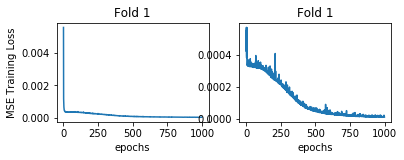

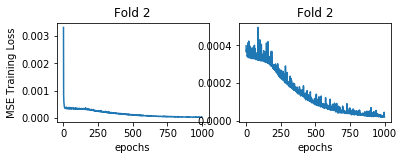

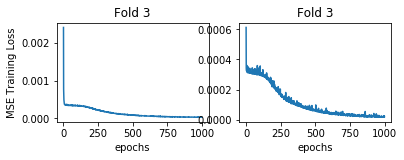

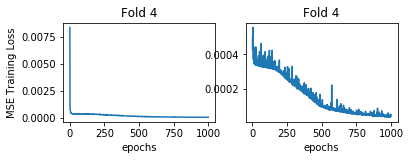

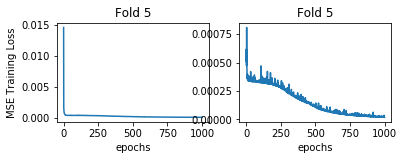

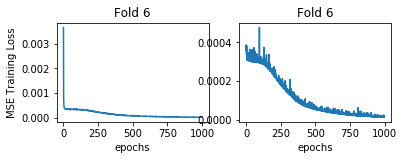

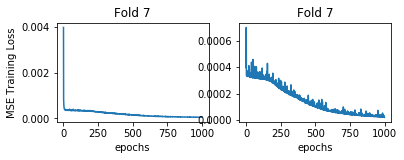

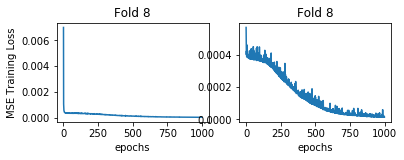

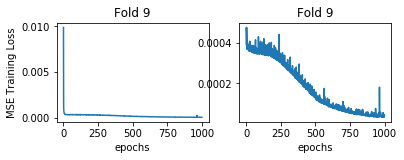

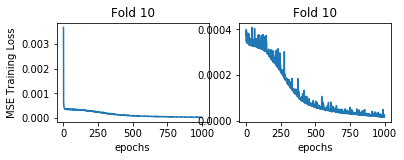

In [15]:
from matplotlib import pyplot as plt

for i,history in enumerate(historiesGRU):
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.title("Fold " + str(i+1))
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.title("Fold " + str(i+1))

    plt.xlabel('epochs')
    plt.show()

# LSTM VS GRU - MSE

After reviewing the loss graphs generated per fold below, the GRU ended up with a lower loss or (MSE) than the LSTM, thus we decided to use the stacked GRU. This result makes sense as GRU's in general perform better on datasets with smaller sample sizes. We understand that when training these models, it is important to have many epochs. While developing the models,  prior to performing cross validation, we compared the performance of LSTM and GRU in the 300 epoch range. It became clear that the GRU performed better. We tested the GRU on 1k epochs and it started to perform very well without overfitting. As a result, whenever we implemented 10-fold cross validation, we did not have time to run a total of 30k epochs for 3 models. These results merely show our comparisons of the losses as we believe this metric is the most relevenat when comparing models attempting to tackle regression

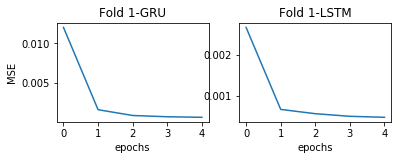

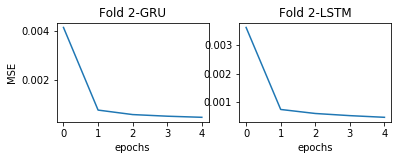

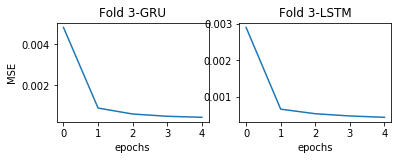

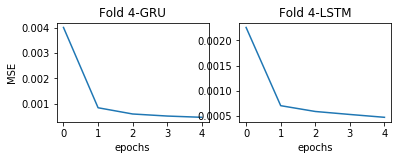

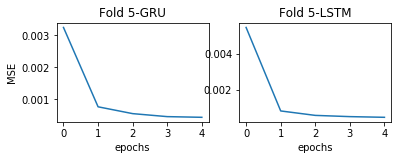

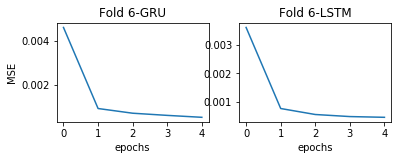

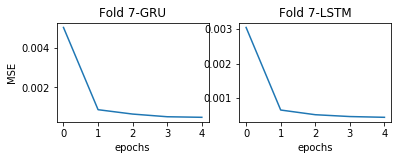

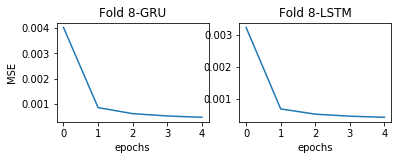

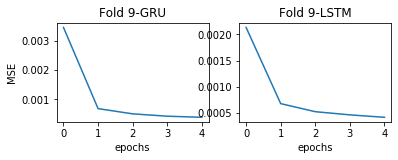

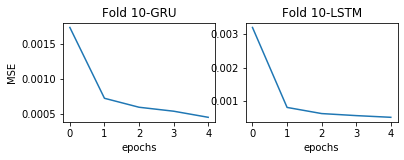

In [63]:
from matplotlib import pyplot as plt

for i,history in enumerate(historiesGRU):
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.title("Fold " + str(i+1) + "-GRU")
    plt.ylabel('MSE')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(historiesLSTM[i].history['loss'])
    plt.title("Fold " + str(i+1)  + "-LSTM")
    plt.xlabel('epochs')
    plt.show()

# Stacked RNN

In [21]:



kfold = KFold(n_splits=10, shuffle=False, random_state=None)
# fit model
historiesStacked = []
stackedModels=[]
# scores = []

k = 1
# for train_index, test_index in kfold.split(xtime, ytarget):
for train_index, test_index in kfold.split(xtime, ytarget):
    modelstacked = Sequential()
    modelstacked.add(GRU(100,dropout=.2,recurrent_dropout=.2,activation='relu', input_shape=(90, 35), return_sequences=True))
    modelstacked.add(GRU(100,dropout=.4,activation='relu', return_sequences=True))

    modelstacked.add(Lambda(lambda x: x[:, -predictedDays:, :]))

    modelstacked.add(Dense(1))

    modelstacked.summary()
    modelstacked.compile(optimizer='adam', loss='mse')
    print("Fold: ", k)
    x_train, x_test = xtime[train_index], xtime[test_index]
    y_train, y_test = ytarget[train_index], ytarget[test_index]
    y_train = y_train.reshape(y_train.shape[0],14,1)
    y_test= y_test.reshape(y_test.shape[0],14,1)
    
    historiesStacked.append(modelstacked.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=5, verbose=1))
    stackedModels.append(modelstacked)
    k += 1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_21 (GRU)                 (None, 90, 100)           40800     
_________________________________________________________________
gru_22 (GRU)                 (None, 90, 100)           60300     
_________________________________________________________________
lambda_54 (Lambda)           (None, 14, 100)           0         
_________________________________________________________________
dense_54 (Dense)             (None, 14, 1)             101       
Total params: 101,201
Trainable params: 101,201
Non-trainable params: 0
_________________________________________________________________
Fold:  1
Train on 1528 samples, validate on 170 samples
Epoch 1/5
1528/1528 [==============================] - 17s 11ms/step - loss: 0.0040 - val_loss: 3.0464e-04
Epoch 2/5
1528/1528 [==============================] - 7s 5ms/step - loss: 8.3369e-04 - val_loss: 4.2092e

1528/1528 [==============================] - 18s 12ms/step - loss: 0.0014 - val_loss: 1.5749e-04
Epoch 2/5
1528/1528 [==============================] - 7s 5ms/step - loss: 4.8301e-04 - val_loss: 1.6592e-04
Epoch 3/5
1528/1528 [==============================] - 7s 5ms/step - loss: 4.4443e-04 - val_loss: 1.5335e-04
Epoch 4/5
1528/1528 [==============================] - 7s 5ms/step - loss: 4.0678e-04 - val_loss: 1.4809e-04
Epoch 5/5
1528/1528 [==============================] - 7s 5ms/step - loss: 3.9820e-04 - val_loss: 1.4755e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_33 (GRU)                 (None, 90, 100)           40800     
_________________________________________________________________
gru_34 (GRU)                 (None, 90, 100)           60300     
_________________________________________________________________
lambda_60 (Lambda)           (None, 14, 100)           0         
_____

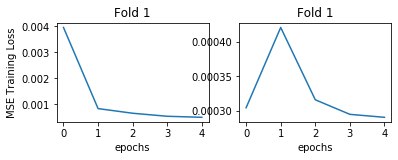

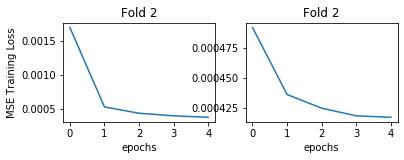

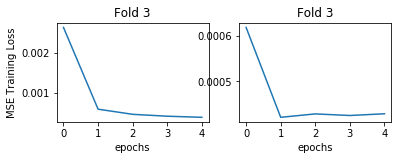

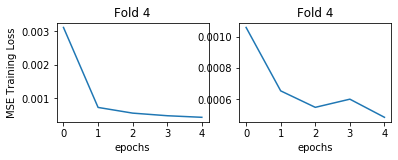

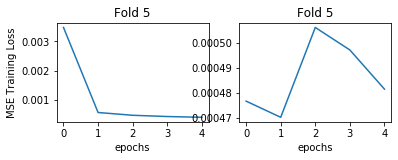

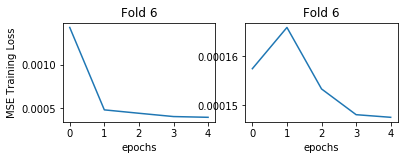

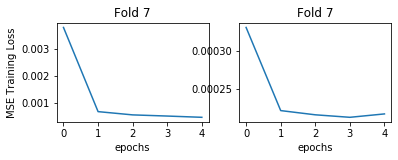

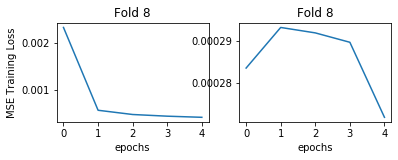

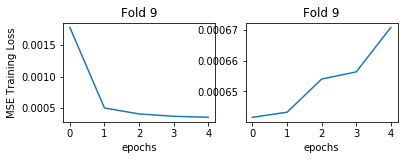

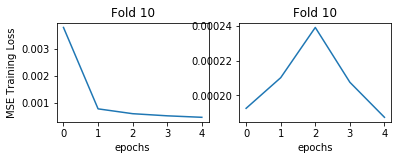

In [22]:
from matplotlib import pyplot as plt

for i,history in enumerate(historiesStacked):
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.title("Fold " + str(i+1))
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.title("Fold " + str(i+1))

    plt.xlabel('epochs')
    plt.show()

# Backtracing

Backtracing is a useful technique to visualize the results of our predictions on the actual dataset. The previous 90 days will be graphed along with the predicted values compared to the actual values. This technique will allow us to determine which patterns the RNN is poor at predicting, which will help give us clarity on how to improve the model beyond looking at convergence metrics. 

# Backtracing GRU Prediction vs Real

90


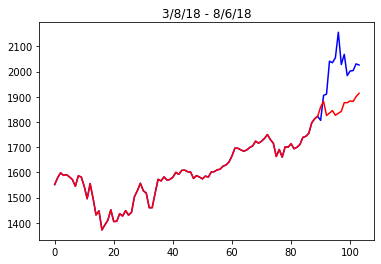

In [43]:
base = 1400
timeplus = 51
yhat = gruModels[5].predict(xtime[base +timeplus][np.newaxis,:,:])

# print(yhat[0] - y_test[0])
backtesting = og[base-90+timeplus:base+timeplus]
print(len(backtesting))
yhatBack=og[base-1+timeplus]
ytestBack = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90+timeplus],ogdates[base+14+timeplus]))

plt.show()


# Backtracing for LSTM and Real

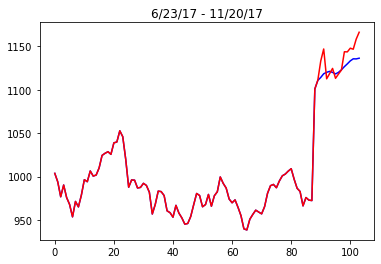

In [40]:
base = 1274
timeplus = 0
yhat = lstmModels[9].predict(xtime[base+timeplus][np.newaxis,:,:])

# print(yhat[0] - y_test[0])
backtesting = og[base-90+timeplus:base+timeplus]
yhatBack=og[base-1+timeplus]
ytestBack = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90+timeplus],ogdates[base+14+timeplus]))

plt.show()


# Backtracing for Stacked GRU and Real

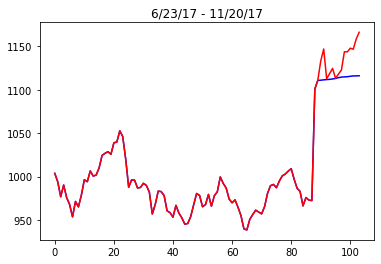

In [42]:
base = 1274
timeplus = 0
yhat = stackedModels[5].predict(xtime[base+timeplus][np.newaxis,:,:])

# print(yhat[0] - y_test[0])
backtesting = og[base-90+timeplus:base+timeplus]
yhatBack=og[base-1+timeplus]
ytestBack = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90+timeplus],ogdates[base+14+timeplus]))

plt.show()


# Extra Credit - Trading Algorithm

The basis of this algorithm is to buy if the prediction belives that the value of the next day will be greater than the current day and vice versa for selling. The ending value will be whatever the algorithm finally sells for on the last day. The algorithm we are comparing to is a simple buy and hold technique over the 14 day period. The time plus variable merely selects a starting point within the x data. Results are returned at the bottom

In [44]:
#making fake data
base = 1274
timeplus = 0
starting_price = og[base-1+timeplus]
price = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]
prices = []
for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    price = price * (1+val)
    
    prices.append(price)
daysPredicted = 14
testArr=[]
for val in range(daysPredicted):
    testArr.append(stackedModels[5].predict(xtime[base + val][np.newaxis,:,:])[0].ravel())

# print(testArr)
# testArr = [[0.2,0.3,-0.2],[0.3,-0.2,0.4],[-0.2,0.4,0.25],[0.4,0.25,-0.1],[0.25,-0.1,-0.2]]
# print(prices)
#start with owning 1 share
bought = True
#owns 1 share
value = 1
#index of time from where we are predicting 
price_index = 0
for i in range(daysPredicted-1,len(testArr)):
    val_for_next_day = 0
    # i2 is for traversing back the amount of days predicted
    i2 = i
    # i3 is for moving to the right position in the specific day to get the next days prediction 
    i3 = 0
    # it starts at 1, goes to 2, and then goes to 3
    # This will predict the next day 
    # [[*,*,3],[*,2,*],[1,*,*]]
    while(i2 > i-daysPredicted):
        val_for_next_day += testArr[i2][i3] * 1/daysPredicted
        i2-=1
        i3+=1
    # if the value for the next day is positive and we haven't bought then we buy
    if(val_for_next_day > 0 and not bought):
        bought = True
        print('bought at',price)
        value = value / price
    # if the value for the next day is negative and we own shares then we sell
    if(val_for_next_day < 0 and bought):
        bought = False
        print('sold at at',price)
        value = price * value
    # set the value to the next closing price
    price_index +=1
    price = prices[price_index]

if(bought):
    value = price * value

#this was made assuming you bought 1 share
print(' Staring Value:',starting_price,'\n',
      'Value of trading alorithm:', value, '\n',
      'Value of buying and holding:',(1*prices[-1]))
#technically we can own fractional parts of share with this algo


NameError: name 'stackedModels' is not defined